# Compare ICESat-2 and the Reanalysis product in the Upper Tuolumne River Basin Above Hetch Hetchy

In [1]:
import numpy as np 
import pandas as pd 
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rxr
import pickle

### Read in the 2 tiles that make up the Upper Tuolumne River Basin below hetch hetchy, where I already have Icesat2 data to test against the reanalysis data:

In [246]:
reanalysis1_2019 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2018_19_SD_POST.nc')
reanalysis2_2019 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2018_19_SD_POST.nc')

reanalysis1_2020 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2019_20_SD_POST.nc')
reanalysis2_2020 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2019_20_SD_POST.nc')

reanalysis1_2021 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SD_POST.nc')
reanalysis2_2021 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SD_POST.nc')

fsca_reanalysis1_2019 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2018_19_SWE_SCA_POST.nc')
fsca_reanalysis2_2019 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2018_19_SWE_SCA_POST.nc')

fsca_reanalysis1_2020 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2019_20_SWE_SCA_POST.nc')
fsca_reanalysis2_2020 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2019_20_SWE_SCA_POST.nc')

fsca_reanalysis1_2021 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc')
fsca_reanalysis2_2021 = xr.open_dataset('../data/reanalysis/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc')


In [245]:
reanalysis1_2019

<xarray.Dataset> Size: 370MB
Dimensions:    (Latitude: 225, Longitude: 225, Day: 365, Stats: 5)
Coordinates:
  * Latitude   (Latitude) float32 900B 38.0 37.99 37.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
Dimensions without coordinates: Day, Stats
Data variables:
    SD_Post    (Day, Stats, Longitude, Latitude) float32 370MB ...

In [24]:
tuol_outline = gpd.read_file('../data/UpperTuolRiverBasinOutline.geojson')

### Combine reanalysis tiles over the Tuolumne:

In [250]:
reanalysis_tuol_2019 = xr.combine_by_coords([reanalysis1_2019, reanalysis2_2019])

reanalysis_tuol_2020 = xr.combine_by_coords([reanalysis1_2020, reanalysis2_2020])

reanalysis_tuol_2021 = xr.combine_by_coords([reanalysis1_2021, reanalysis2_2021])

fsca_reanalysis_tuol_2019 = xr.combine_by_coords([fsca_reanalysis1_2019, fsca_reanalysis2_2019])

fsca_reanalysis_tuol_2020 = xr.combine_by_coords([fsca_reanalysis1_2020, fsca_reanalysis2_2020])

fsca_reanalysis_tuol_2021 = xr.combine_by_coords([fsca_reanalysis1_2021, fsca_reanalysis2_2021])

In [253]:
fsca_reanalysis_tuol_2021

<xarray.Dataset> Size: 1GB
Dimensions:    (Day: 365, Stats: 5, Longitude: 225, Latitude: 450)
Coordinates:
  * Latitude   (Latitude) float32 2kB 39.0 38.99 38.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
Dimensions without coordinates: Day, Stats
Data variables:
    SWE_Post   (Day, Stats, Longitude, Latitude) float32 739MB 0.0 0.0 ... 0.0
    SCA_Post   (Day, Stats, Longitude, Latitude) float32 739MB 0.0 0.0 ... 0.0

In [251]:
import datetime

def day_of_year(date):
    # Check if it's a leap year
    leap_year = date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0)
    
    # Define days in each month, accounting for leap year
    days_in_month = [31, 29 if leap_year else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    # Calculate day of the year
    day_count = sum(days_in_month[i] for i in range(date.month - 1)) + date.day
    
    return day_count

# Example usage
date = datetime.date(2024, 5, 9)
print("Day of the year:", day_of_year(date))

Day of the year: 130


In [252]:
def subset_reanalysis(ds, out_fn):
    # read in and format large SWE Reanalysis file:
    
    #ds = xr.open_dataset(ds_fn)
    ds.rio.write_crs('EPSG:4326',inplace = True)
    if 'Latitude' in ds.dims:
        ds = ds.rename({'Latitude':'y','Longitude':'x'})
    
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)

    # Subset to the correct day and statistic, and read out as a new file:
    ds_stat = ds.sel({'Stats': 2})
    ds_stat = ds_stat.SD_Post.T
    ds_stat.to_netcdf(out_fn)
    
    return ds_stat

### Preprocess the reanalysis data to give only the statistics we want (ensemble median):

In [9]:
!pwd

/Users/hannah/Documents/Grad_Documents/Research/analog_snowmapping/notebooks


In [249]:
reanalysis_processed_2019 = subset_reanalysis(reanalysis_tuol_2019,'../data/reanalysis/reanalysis_tuol_processed_2019.nc')

reanalysis_processed_2020 = subset_reanalysis(reanalysis_tuol_2020,'../data/reanalysis/reanalysis_tuol_processed_2020.nc')

reanalysis_processed_2021 = subset_reanalysis(reanalysis_tuol_2021,'../data/reanalysis/reanalysis_tuol_processed_2021.nc')

In [254]:
def subset_reanalysis(ds, out_fn):
    # read in and format large SWE Reanalysis file:
    
    #ds = xr.open_dataset(ds_fn)
    ds.rio.write_crs('EPSG:4326',inplace = True)
    if 'Latitude' in ds.dims:
        ds = ds.rename({'Latitude':'y','Longitude':'x'})
    
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)

    # Subset to the correct day and statistic, and read out as a new file:
    ds_stat = ds.sel({'Stats': 2})
    ds_stat = ds_stat.SCA_Post.T
    ds_stat.to_netcdf(out_fn)
    
    return ds_stat

In [255]:
fsca_reanalysis_processed_2019 = subset_reanalysis(fsca_reanalysis_tuol_2019,'../data/reanalysis/reanalysis_tuol_processed_fsca_2019.nc')

fsca_reanalysis_processed_2020 = subset_reanalysis(fsca_reanalysis_tuol_2020,'../data/reanalysis/reanalysis_tuol_processed_fsca_2020.nc')

fsca_reanalysis_processed_2021 = subset_reanalysis(fsca_reanalysis_tuol_2021,'../data/reanalysis/reanalysis_tuol_processed_fsca_2021.nc')

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

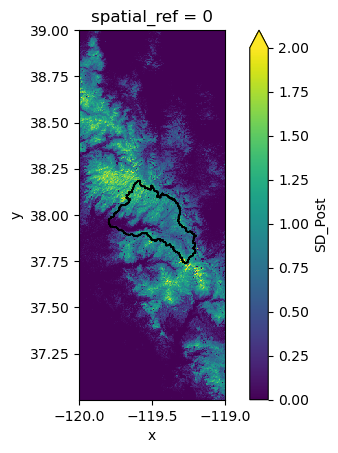

In [25]:
fig, ax = plt.subplots()
reanalysis_processed_2019[:,:,100].plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')


### Load ICESat-2 data from Masters work:

In [26]:
atl06sr_gdf = pickle.load(open('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))

/var/folders/s4/pymynk_14w75x2ghv0xjkqlm0000gn/T/ipykernel_22703/2397239878.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  atl06sr_gdf = pickle.load(open('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso.pkl', 'rb'))


In [27]:
atl06sr_gdf

distance   h_sigma   rgt    delta_time  \
time                                                                        
2018-10-15 23:22:20.018965444  4.215353e+06  0.033182   265  2.488094e+07   
2018-10-15 23:22:20.021811344  4.215373e+06  0.028329   265  2.488094e+07   
2018-10-15 23:22:20.027481712  4.215413e+06  0.032855   265  2.488094e+07   
2018-10-15 23:22:20.030305900  4.215434e+06  0.041974   265  2.488094e+07   
2018-10-15 23:22:20.033126928  4.215454e+06  0.045422   265  2.488094e+07   
...                                     ...       ...   ...           ...   
2022-06-06 07:52:14.166292256  4.221955e+06  0.103436  1149  1.397371e+08   
2022-06-06 07:52:14.174719728  4.222015e+06  0.101625  1149  1.397371e+08   
2022-06-06 07:52:14.177525200  4.222035e+06  0.093427  1149  1.397371e+08   
2022-06-06 07:52:14.183137424  4.222075e+06  0.120022  1149  1.397371e+08   
2022-06-06 07:52:14.185946192  4.222095e+06  0.141535  1149  1.397371e+08   

                               pflags  dh_fit_dy  segment_id  \
time                                                           
2018-10-15 23:22:20.018965444       0        0.0      210188   
2018-10-15 23:22:20.021811344       0        0.0      210189   
2018-10-15 23:22:20.027481712       0        0.0      210191   
2018-10-15 23:22:20.030305900       0        0.0      210192   
2018-10-15 23:22:20.033126928       0        0.0      210193   
...                               ...        ...         ...   
2022-06-06 07:52:14.166292256       0        0.0      210520   
2022-06-06 07:52:14.174719728       0        0.0      210523   
2022-06-06 07:52:14.177525200       0        0.0      210524   
2022-06-06 07:52:14.183137424       0        0.0      210526   
2022-06-06 07:52:14.185946192       0        0.0      210527   

                               w_surface_window_final  dh_fit_dx       h_mean  \
time                                                                            
2018-10-15 23:22:20.018965444                3.000000  -0.018228  2501.377184   
2018-10-15 23:22:20.021811344                3.000000  -0.010939  2501.116873   
2018-10-15 23:22:20.027481712                3.000000  -0.000515  2501.053838   
2018-10-15 23:22:20.030305900                3.000000   0.008181  2501.176924   
2018-10-15 23:22:20.033126928                3.000000   0.004802  2501.271832   
...                                               ...        ...          ...   
2022-06-06 07:52:14.166292256                8.424878  -0.329516  3501.549246   
2022-06-06 07:52:14.174719728                9.093066  -0.355783  3483.510153   
2022-06-06 07:52:14.177525200               10.206696  -0.399543  3476.005923   
2022-06-06 07:52:14.183137424                9.441717  -0.369486  3462.032878   
2022-06-06 07:52:14.185946192               10.012953  -0.391932  3454.424594   

                               ...      site     acqdate     n  diff_plus  \
time                           ...                                          
2018-10-15 23:22:20.018965444  ...  tuolumne  2018-10-15   919  -0.178201   
2018-10-15 23:22:20.021811344  ...  tuolumne  2018-10-15   919   0.061488   
2018-10-15 23:22:20.027481712  ...  tuolumne  2018-10-15   919  -0.011557   
2018-10-15 23:22:20.030305900  ...  tuolumne  2018-10-15   919   0.171344   
2018-10-15 23:22:20.033126928  ...  tuolumne  2018-10-15   919  -0.173689   
...                            ...       ...         ...   ...        ...   
2022-06-06 07:52:14.166292256  ...  tuolumne  2022-06-06  2311        NaN   
2022-06-06 07:52:14.174719728  ...  tuolumne  2022-06-06  2311        NaN   
2022-06-06 07:52:14.177525200  ...  tuolumne  2022-06-06  2311        NaN   
2022-06-06 07:52:14.183137424  ...  tuolumne  2022-06-06  2311        NaN   
2022-06-06 07:52:14.185946192  ...  tuolumne  2022-06-06  2311        NaN   

                               diff_plus_bicubic    zscore  ASO_snowon  \
time                                                                  

### Re-pickle because of deprecation warning:

In [28]:
atl06sr_gdf.to_pickle('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso_shapely.pkl')

In [29]:
atl06sr_gdf = pickle.load(open('../data/icesat2/tuolumne_all_sr-atl06-09282022_processed_bicubic_snowonaso_shapely.pkl', 'rb'))

In [45]:
atl06sr_gdf.columns

Index(['distance', 'h_sigma', 'rgt', 'delta_time', 'pflags', 'dh_fit_dy',
       'segment_id', 'w_surface_window_final', 'dh_fit_dx', 'h_mean', 'spot',
       'gt', 'cycle', 'rms_misfit', 'n_fit_photons', 'geometry', 'doy',
       'decyear', 'dowy', 'snow_presence', 'lidar_z', 'difference',
       'bicubic_lidar_z', 'sampling_dif', 'difference_bicubic', 'site',
       'acqdate', 'n', 'diff_plus', 'diff_plus_bicubic', 'zscore',
       'ASO_snowon', 'ASO_snowon_date', 'ASO_snowon_bic', 'median_slope20d'],
      dtype='object')

### Define relevant snow-on dates on which to compare IS2 and reanalysis:

In [41]:
snowon_dates = list(atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['acqdate'].unique())

In [42]:
snowon_dates

[datetime.date(2018, 12, 11),
 datetime.date(2019, 1, 9),
 datetime.date(2019, 3, 12),
 datetime.date(2019, 4, 10),
 datetime.date(2019, 5, 14),
 datetime.date(2019, 12, 9),
 datetime.date(2019, 12, 11),
 datetime.date(2020, 1, 7),
 datetime.date(2020, 1, 13),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 10),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 12, 6),
 datetime.date(2020, 12, 8),
 datetime.date(2021, 1, 10),
 datetime.date(2021, 2, 2),
 datetime.date(2021, 2, 8),
 datetime.date(2021, 3, 7),
 datetime.date(2021, 3, 13),
 datetime.date(2021, 4, 5),
 datetime.date(2021, 4, 11),
 datetime.date(2021, 5, 10),
 datetime.date(2022, 1, 3),
 datetime.date(2022, 1, 8),
 datetime.date(2022, 2, 6),
 datetime.date(2022, 4, 3)]

<Axes: >

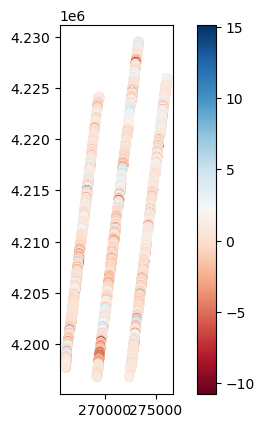

In [368]:
fig, ax = plt.subplots()
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[0])].plot(column='diff_plus_bicubic',ax=ax, legend=True, cmap='RdBu')

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x', ylabel='y'>

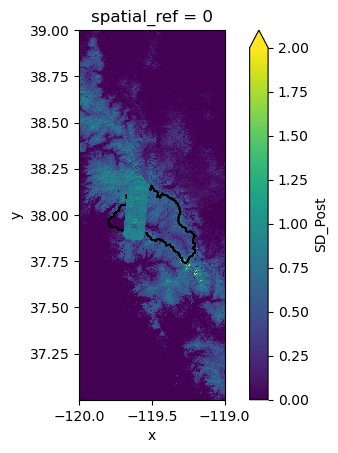

In [59]:
fig, ax = plt.subplots()
reanalysis_processed[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[0]]['dowy'].unique()].plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[0])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax)

### Calculate median snow depth over the entire basin:

In [135]:
reanalysis_clipped_2019 = reanalysis_processed_2019.rio.clip(tuol_outline.geometry)

reanalysis_clipped_2020 = reanalysis_processed_2020.rio.clip(tuol_outline.geometry)

reanalysis_clipped_2021 = reanalysis_processed_2021.rio.clip(tuol_outline.geometry)

In [256]:
fsca_reanalysis_clipped_2019 = fsca_reanalysis_processed_2019.rio.clip(tuol_outline.geometry)

fsca_reanalysis_clipped_2020 = fsca_reanalysis_processed_2020.rio.clip(tuol_outline.geometry)

fsca_reanalysis_clipped_2021 = fsca_reanalysis_processed_2021.rio.clip(tuol_outline.geometry)

Not sure how to deal with snow-off values in the ICESat-2 data. I exclude 0 values in the reanalysis data, but then do I use a current-year snow cover product, or brightness values in the ICESat-2 data? I showed that brightness values could be used in Tuolumne (as did Cesar) but not in the Methow, so is it still valid to use the in the Sierra?

### Populate a columne of the is2 dataframe with fsca sampled from the reanalysis on the corresponding date:

In [360]:
date_index=0

x_coord = [pt.x for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').geometry]
y_coord = [pt.y for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').geometry]

atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]), ['reanalysis_fsca']] = reanalysis_fsca.sel(x=x_coord, y=y_coord, method='nearest').values.diagonal().T.squeeze()

In [305]:
snowon_dates[0:5]


[datetime.date(2018, 12, 11),
 datetime.date(2019, 1, 9),
 datetime.date(2019, 3, 12),
 datetime.date(2019, 4, 10),
 datetime.date(2019, 5, 14)]

In [306]:
snowon_dates[5:15]

[datetime.date(2019, 12, 9),
 datetime.date(2019, 12, 11),
 datetime.date(2020, 1, 7),
 datetime.date(2020, 1, 13),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 10),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 12)]

In [310]:
snowon_dates[15:25]

[datetime.date(2020, 12, 6),
 datetime.date(2020, 12, 8),
 datetime.date(2021, 1, 10),
 datetime.date(2021, 2, 2),
 datetime.date(2021, 2, 8),
 datetime.date(2021, 3, 7),
 datetime.date(2021, 3, 13),
 datetime.date(2021, 4, 5),
 datetime.date(2021, 4, 11),
 datetime.date(2021, 5, 10)]

In [362]:
# 2019:

for date_index in snowon_dates[0:5]:
    reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==date_index]['dowy'].unique()]
    x_coord = [pt.x for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    y_coord = [pt.y for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index), ['reanalysis_fsca']] = reanalysis_fsca.sel(x=x_coord, y=y_coord, method='nearest').values.diagonal().T

# 2020:

for date_index in snowon_dates[5:15]:
    reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==date_index]['dowy'].unique()]
    x_coord = [pt.x for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    y_coord = [pt.y for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index), ['reanalysis_fsca']] = reanalysis_fsca.sel(x=x_coord, y=y_coord, method='nearest').values.diagonal().T

# 2021:

for date_index in snowon_dates[15:25]:
    reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==date_index]['dowy'].unique()]
    x_coord = [pt.x for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    y_coord = [pt.y for pt in atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index)].to_crs('epsg:4326').geometry]
    atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date_index), ['reanalysis_fsca']] = reanalysis_fsca.sel(x=x_coord, y=y_coord, method='nearest').values.diagonal().T

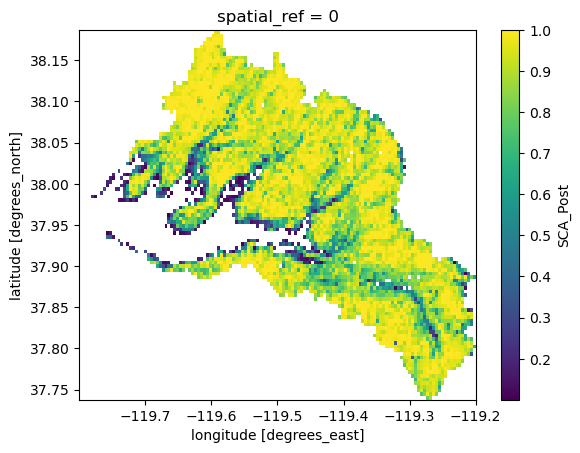

In [260]:
reanalysis_fsca.where(reanalysis_fsca>0.1).plot()

Text(0.5, 1.0, '2021-05-10')

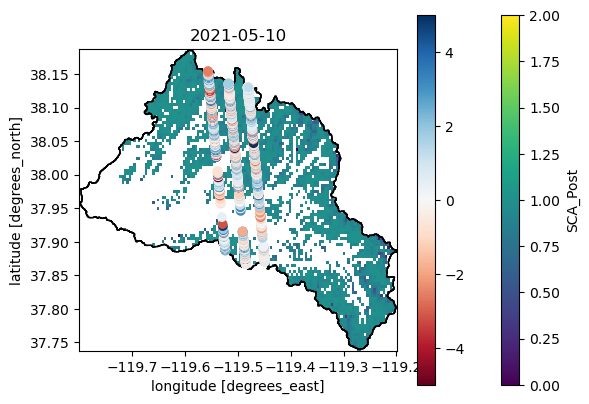

In [261]:
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
is2 = atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326')
is2['fsca_reanalysis'] = 

fig, ax = plt.subplots()
reanalysis_fsca.where(reanalysis_test>0.1).plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

make a subset of the icesat2 data based on the date. Then sample the fsca data array at each point, and use that column as a conditional of whether to include the icesat-2 point in the plots and median values.

In [374]:
date_index =0

In [373]:
snowon_dates[0]

datetime.date(2018, 12, 11)

In [375]:
snowon_dates[date_index]

datetime.date(2018, 12, 11)

In [371]:
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[0])]

distance   h_sigma   rgt    delta_time  \
time                                                                        
2018-12-11 08:53:00.121753424  1.582237e+07  0.046549  1126  2.975358e+07   
2018-12-11 08:53:00.124567280  1.582239e+07  0.072951  1126  2.975358e+07   
2018-12-11 08:53:00.130217820  1.582243e+07  0.107678  1126  2.975358e+07   
2018-12-11 08:53:00.133047480  1.582245e+07  0.104155  1126  2.975358e+07   
2018-12-11 08:53:00.150044280  1.582257e+07  0.174431  1126  2.975358e+07   
...                                     ...       ...   ...           ...   
2018-12-11 08:53:05.148196040  1.585570e+07  0.029269  1126  2.975359e+07   
2018-12-11 08:53:05.150989896  1.585572e+07  0.050507  1126  2.975359e+07   
2018-12-11 08:53:05.153783736  1.585574e+07  0.047248  1126  2.975359e+07   
2018-12-11 08:53:05.156582808  1.585576e+07  0.074080  1126  2.975359e+07   
2018-12-11 08:53:05.159388348  1.585578e+07  0.048853  1126  2.975359e+07   

                               pflags  dh_fit_dy  segment_id  \
time                                                           
2018-12-11 08:53:00.121753424       0        0.0      789953   
2018-12-11 08:53:00.124567280       0        0.0      789954   
2018-12-11 08:53:00.130217820       0        0.0      789956   
2018-12-11 08:53:00.133047480       0        0.0      789957   
2018-12-11 08:53:00.150044280       0        0.0      789963   
...                               ...        ...         ...   
2018-12-11 08:53:05.148196040       0        0.0      791616   
2018-12-11 08:53:05.150989896       0        0.0      791617   
2018-12-11 08:53:05.153783736       0        0.0      791618   
2018-12-11 08:53:05.156582808       0        0.0      791619   
2018-12-11 08:53:05.159388348       0        0.0      791620   

                               w_surface_window_final  dh_fit_dx       h_mean  \
time                                                                            
2018-12-11 08:53:00.121753424                3.000000   0.054320  3142.654622   
2018-12-11 08:53:00.124567280                3.088237   0.118709  3144.413626   
2018-12-11 08:53:00.130217820                3.000000  -0.107540  3143.755805   
2018-12-11 08:53:00.133047480                3.069950  -0.117977  3141.496978   
2018-12-11 08:53:00.150044280               12.856402  -0.503602  3109.734898   
...                                               ...        ...          ...   
2018-12-11 08:53:05.148196040                7.409657   0.289583  2515.233253   
2018-12-11 08:53:05.150989896                9.368451   0.366607  2521.917236   
2018-12-11 08:53:05.153783736               11.032542   0.431983  2530.107320   
2018-12-11 08:53:05.156582808               10.246411   0.401104  2538.177914   
2018-12-11 08:53:05.159388348               11.827491   0.463203  2546.687239   

                               ...     acqdate     n  diff_plus  \
time                           ...                                
2018-12-11 08:53:00.121753424  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:00.124567280  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:00.130217820  ...  2018-12-11  6215   1.177227   
2018-12-11 08:53:00.133047480  ...  2018-12-11  6215   0.268497   
2018-12-11 08:53:00.150044280  ...  2018-12-11  6215   0.268380   
...                            ...         ...   ...        ...   
2018-12-11 08:53:05.148196040  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:05.150989896  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:05.153783736  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:05.156582808  ...  2018-12-11  6215        NaN   
2018-12-11 08:53:05.159388348  ...  2018-12-11  6215        NaN   

                               diff_plus_bicubic    zscore ASO_snowon  \
time                                                                    
2018-12-11 08:53:00.121753424                NaN       NaN        NaN   
2018-12-11 08:53:00.124567280                NaN       

In [378]:
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']

time
2018-12-11 08:53:00.121753424         NaN
2018-12-11 08:53:00.124567280         NaN
2018-12-11 08:53:00.130217820    1.230901
2018-12-11 08:53:00.133047480    0.510397
2018-12-11 08:53:00.150044280   -0.621090
                                   ...   
2018-12-11 08:53:05.108532540   -0.207285
2018-12-11 08:53:05.111348520    0.486198
2018-12-11 08:53:05.114172264    0.782454
2018-12-11 08:53:05.117008848         NaN
2018-12-11 08:53:05.119862496         NaN
Name: diff_plus_bicubic, Length: 5592, dtype: float64

In [367]:
snowon_dates[0]

datetime.date(2018, 12, 11)

Text(0.5, 1.0, '2018-12-11')

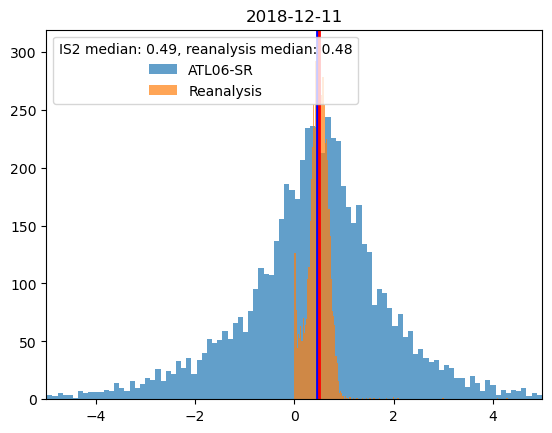

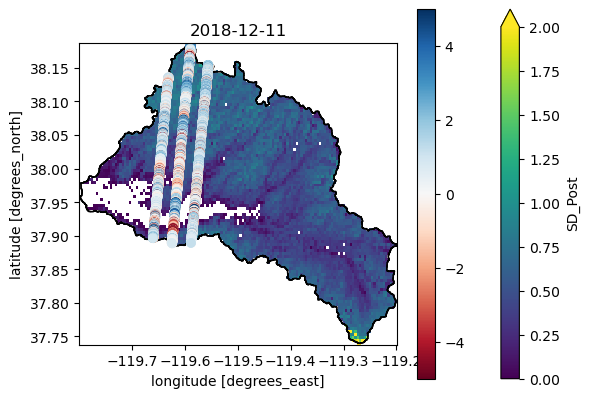

In [380]:
date_index = 0

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 5)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2018-12-11')

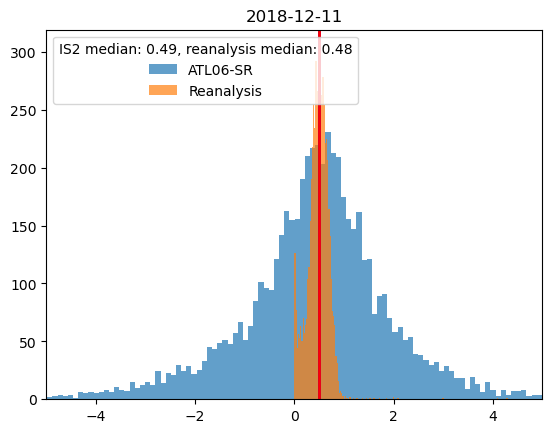

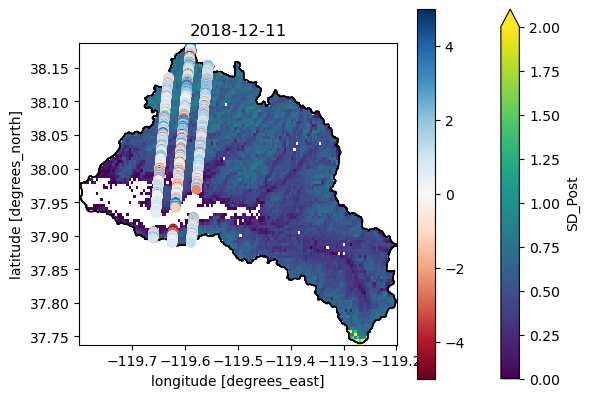

In [379]:
date_index = 0

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 5)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2019-01-09')

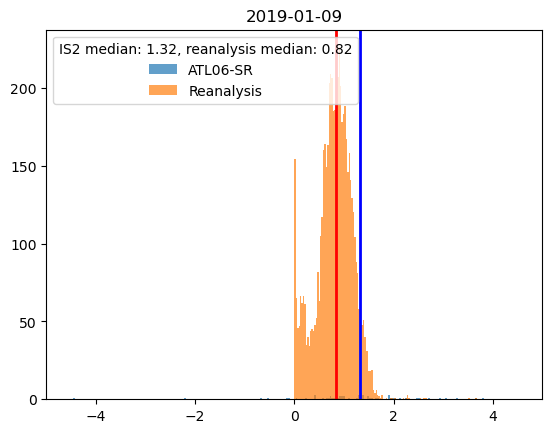

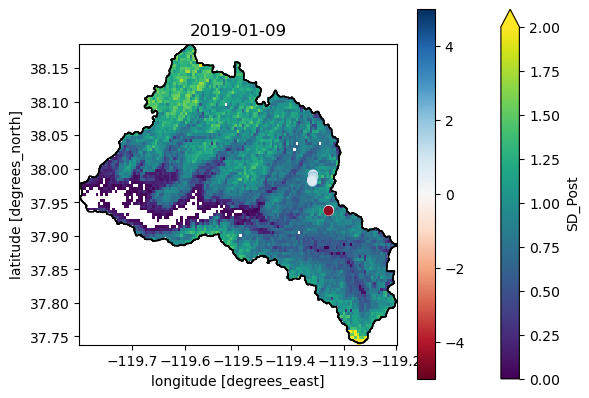

In [381]:
date_index = 1

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 5)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-01-09')

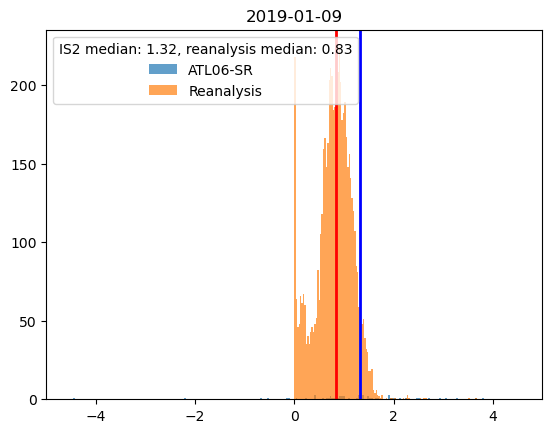

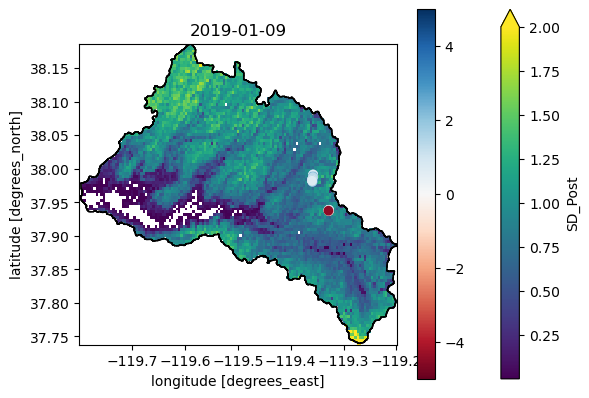

In [220]:
date_index = 1

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 5)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=2)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2019-03-12')

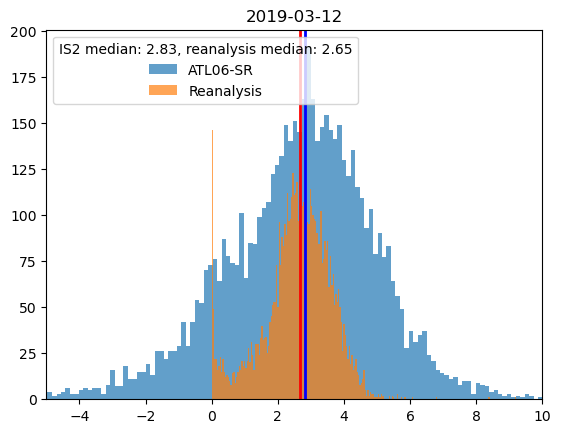

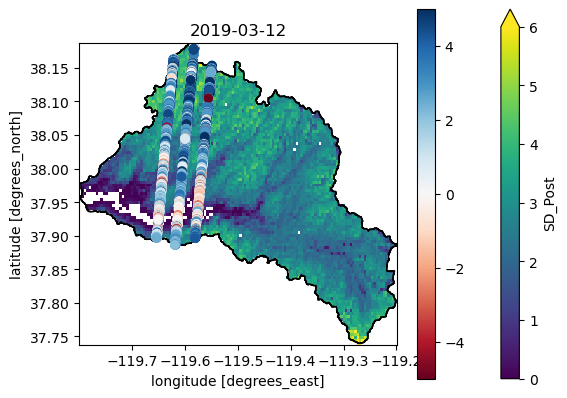

In [383]:
date_index = 2

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-03-12')

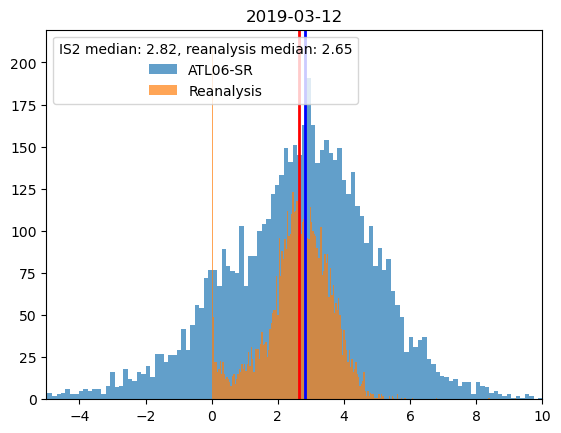

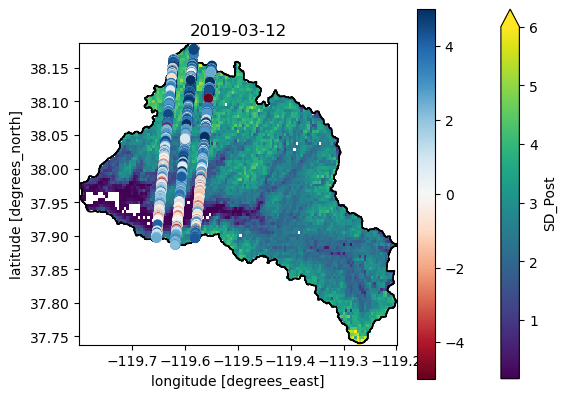

In [223]:
date_index = 2

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2019-04-10')

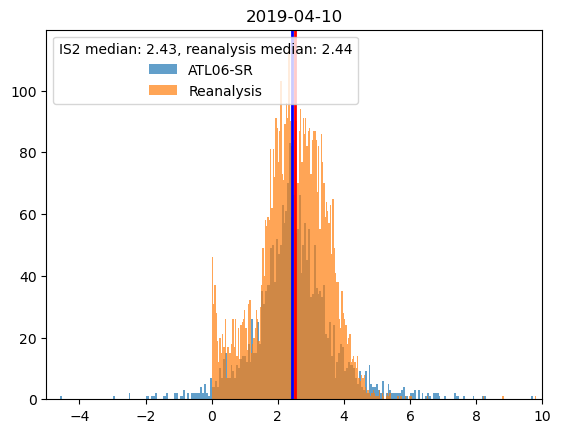

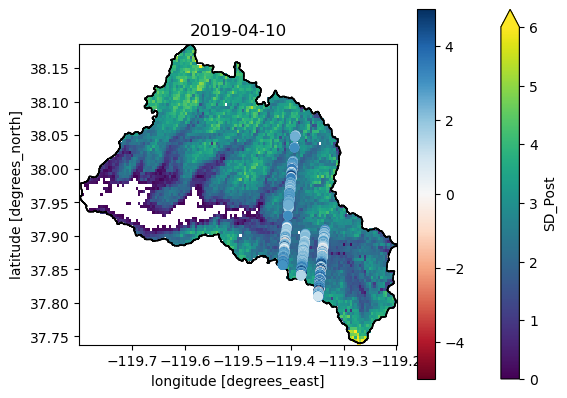

In [385]:
date_index = 3

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-04-10')

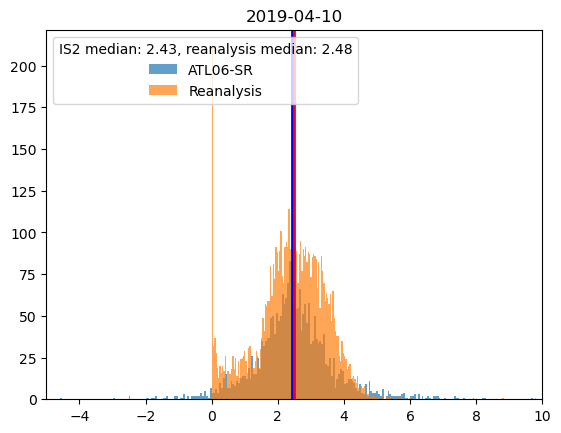

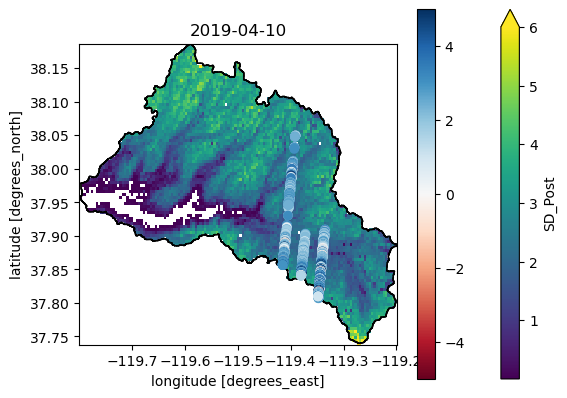

In [224]:
date_index = 3

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2019-05-14')

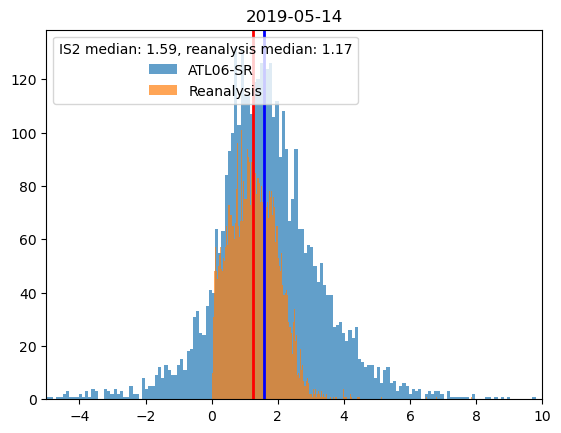

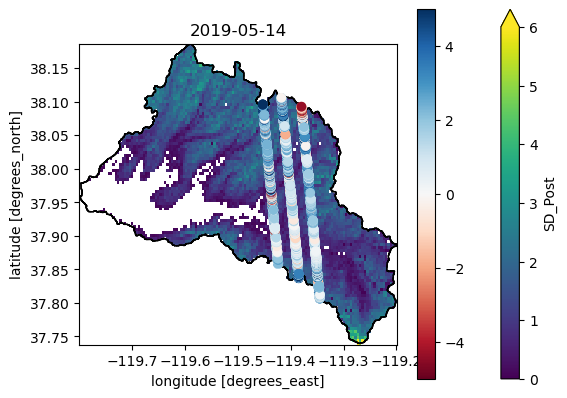

In [386]:
date_index = 4

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-05-14')

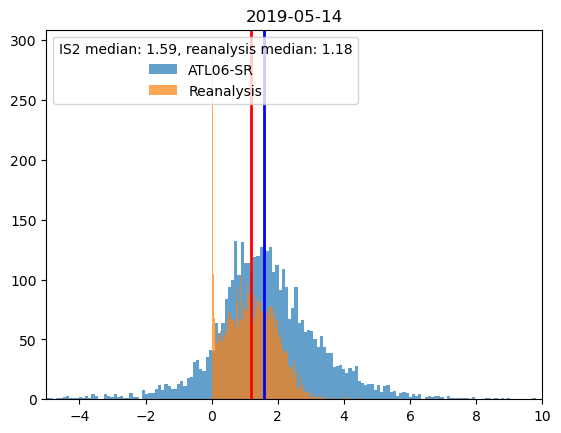

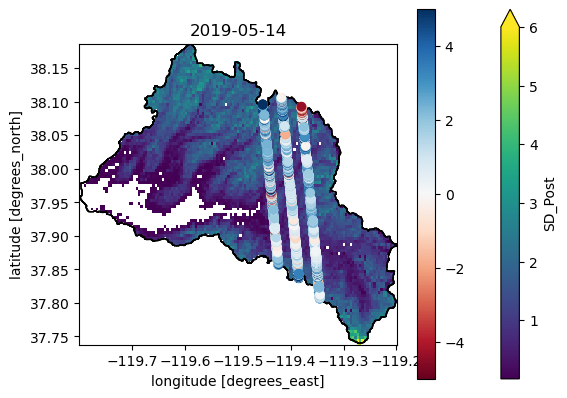

In [225]:
date_index = 4

reanalysis_test = reanalysis_clipped_2019[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

### Water Year 2020:

Text(0.5, 1.0, '2019-12-09')

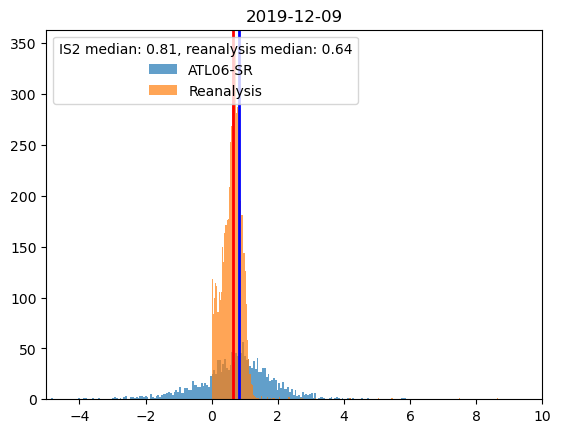

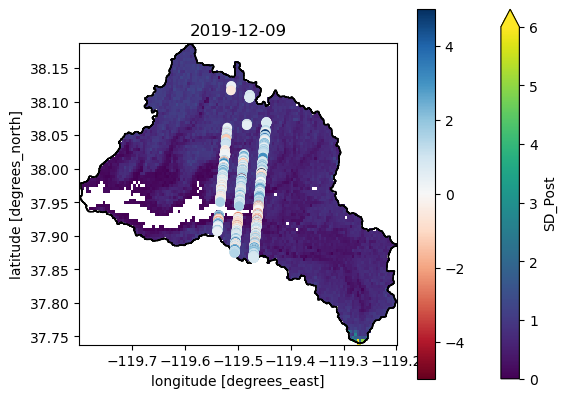

In [387]:
date_index = 5

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-12-09')

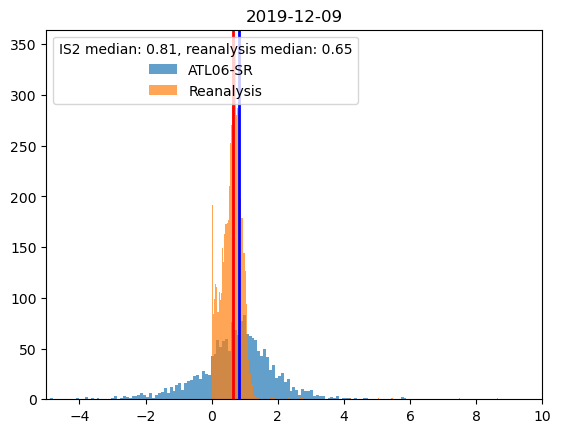

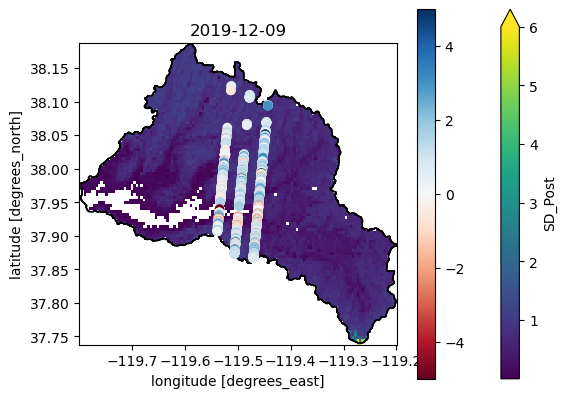

In [388]:
date_index = 5

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2019-12-11')

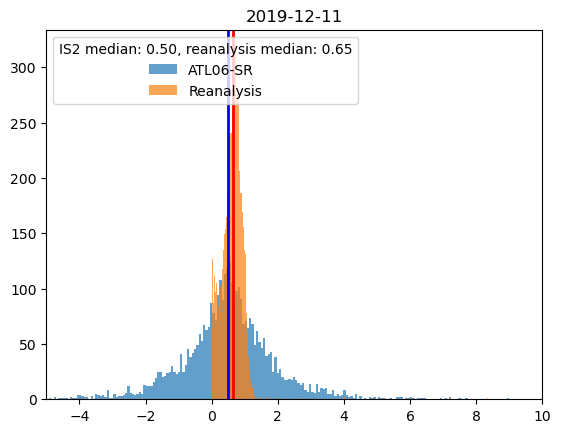

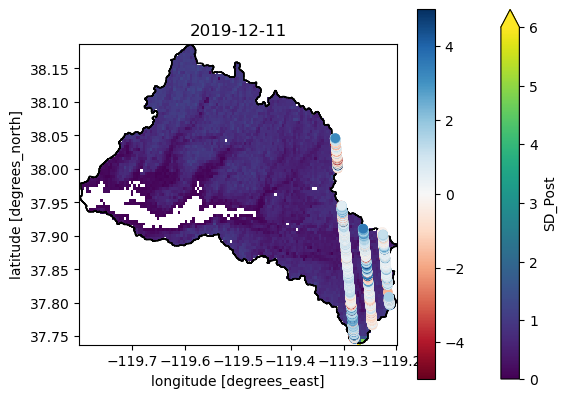

In [389]:
date_index = 6

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2019-12-11')

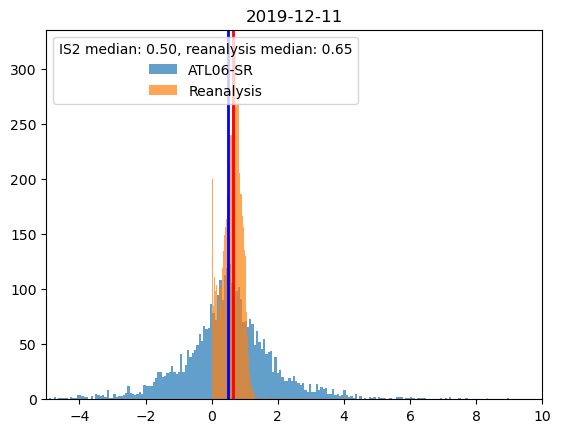

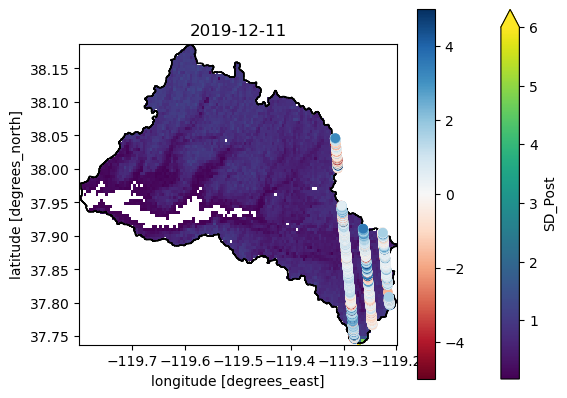

In [227]:
date_index = 6

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-01-07')

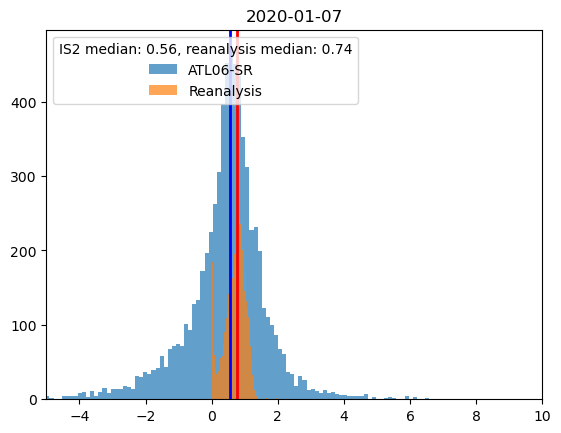

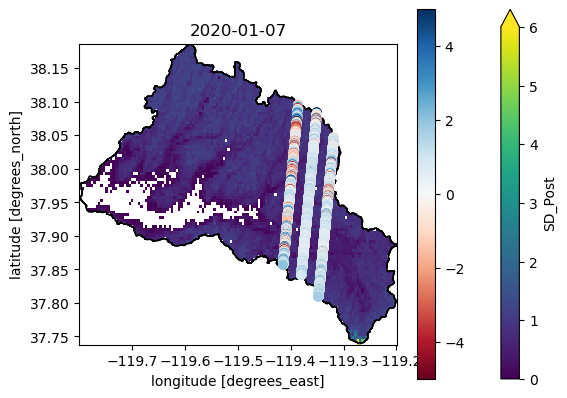

In [390]:
date_index = 7

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-01-07')

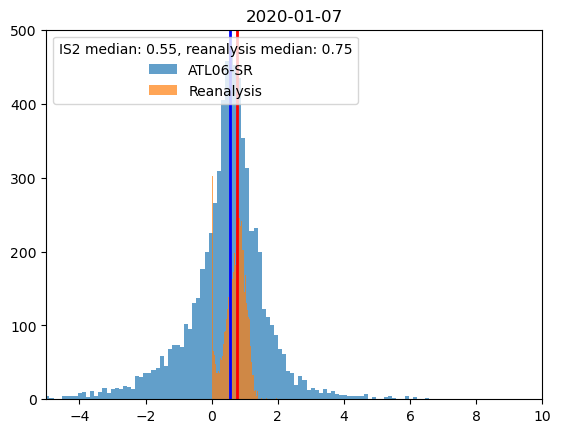

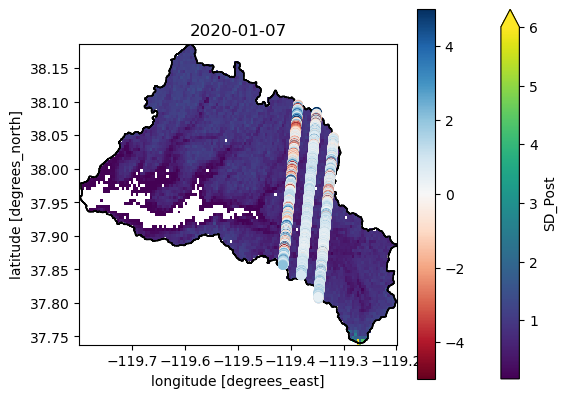

In [228]:
date_index = 7

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-01-13')

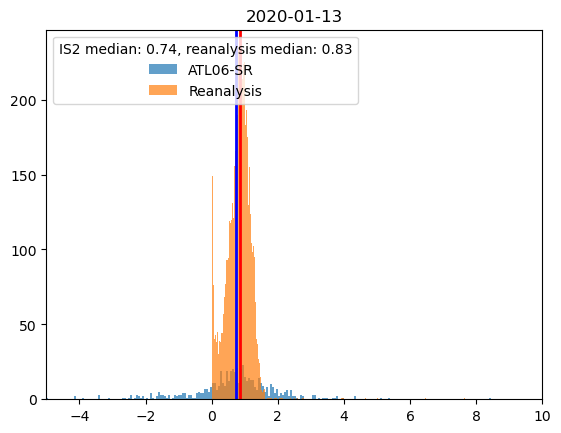

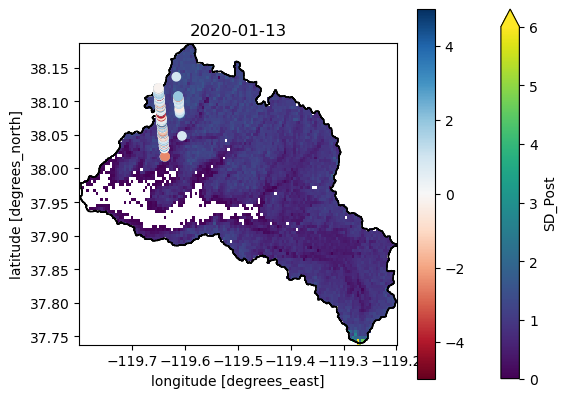

In [391]:
date_index = 8

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-01-13')

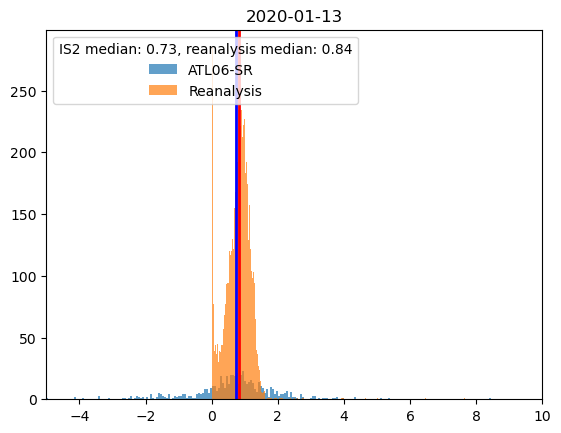

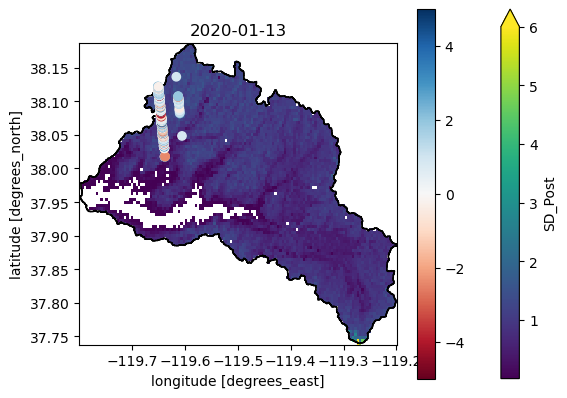

In [229]:
date_index = 8

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-02-05')

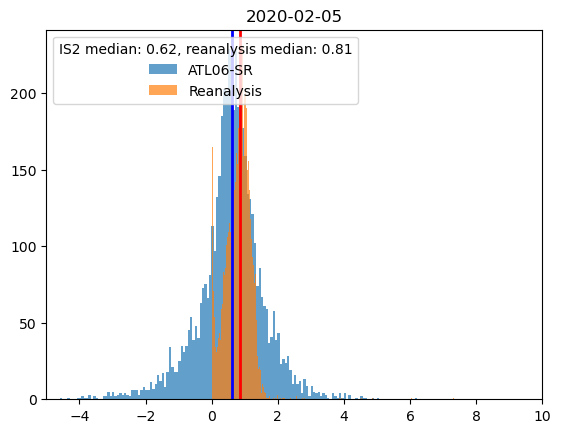

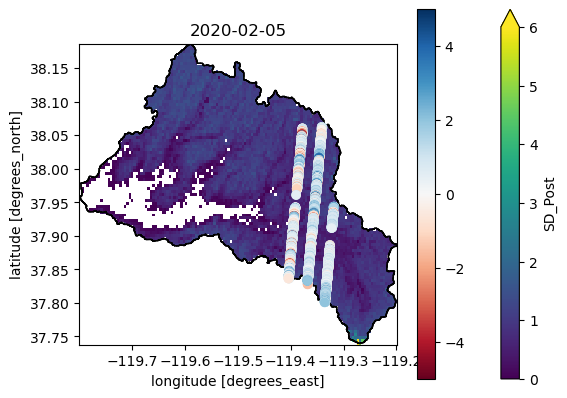

In [392]:
date_index = 9

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-02-05')

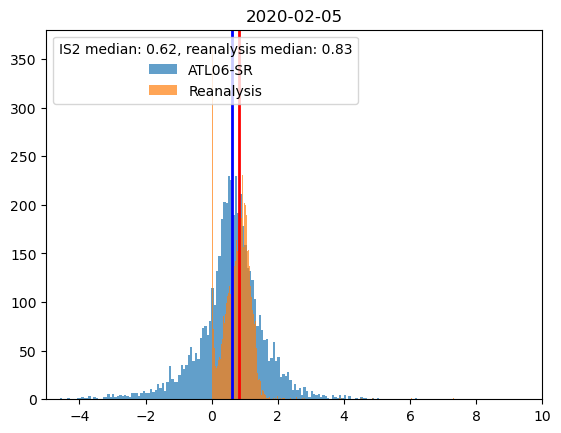

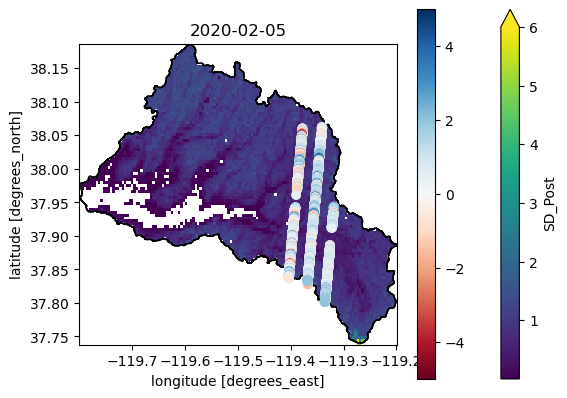

In [230]:
date_index = 9

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-02-11')

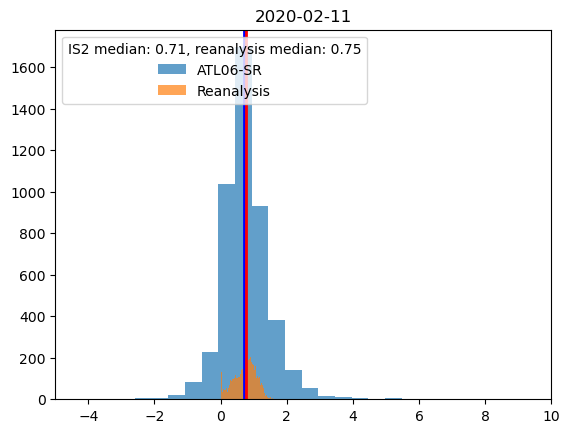

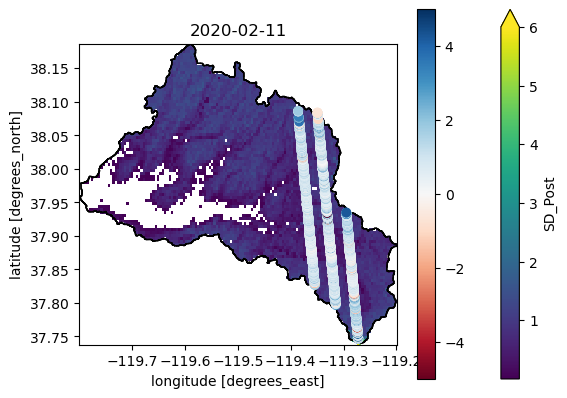

In [393]:
date_index = 10

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-02-11')

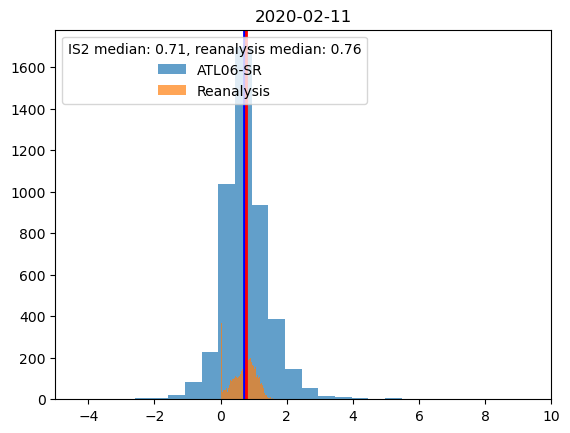

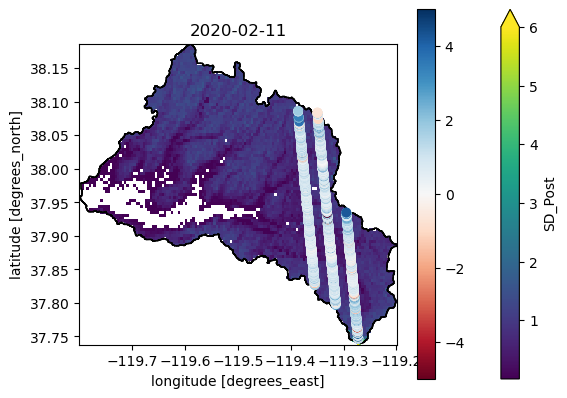

In [231]:
date_index = 10

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-03-09')

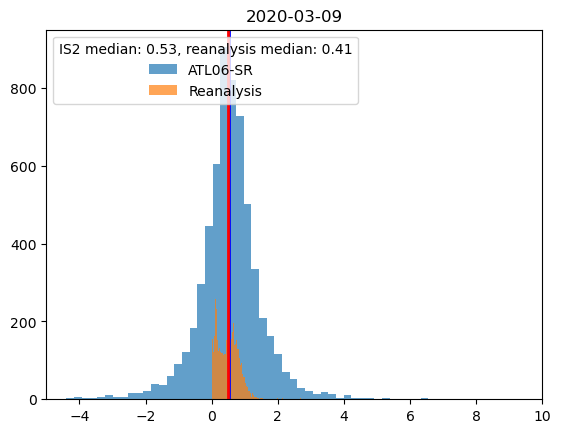

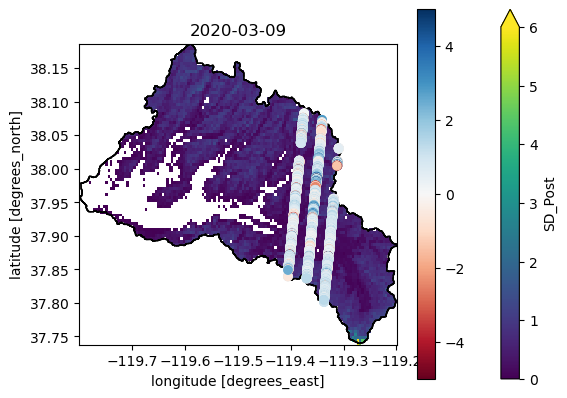

In [394]:
date_index = 11

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-03-09')

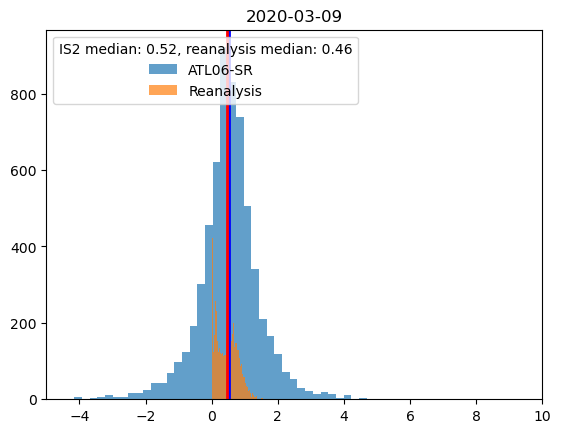

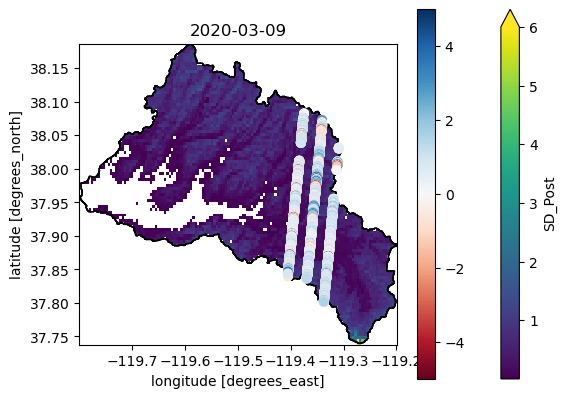

In [232]:
date_index = 11

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-03-10')

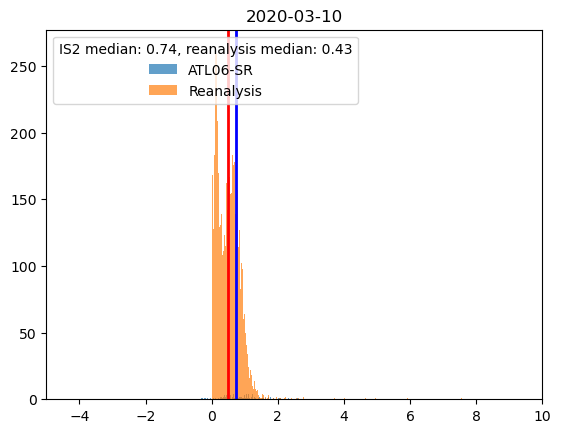

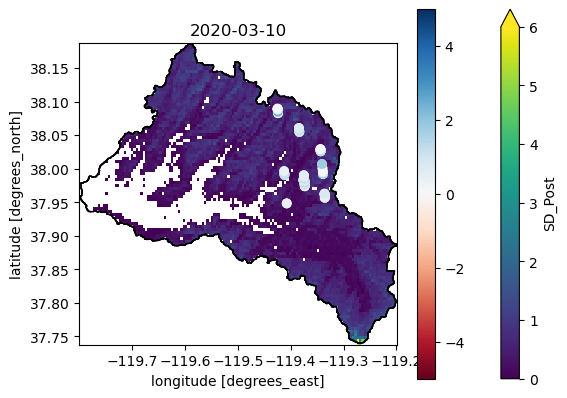

In [395]:
date_index = 12

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-03-10')

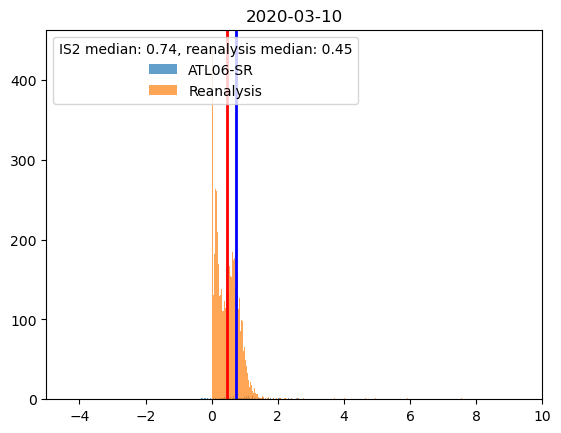

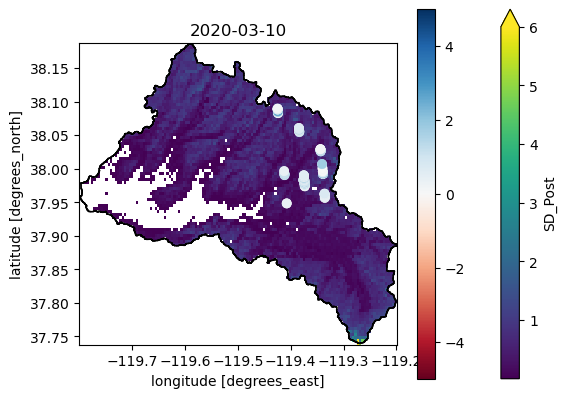

In [233]:
date_index = 12

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-04-07')

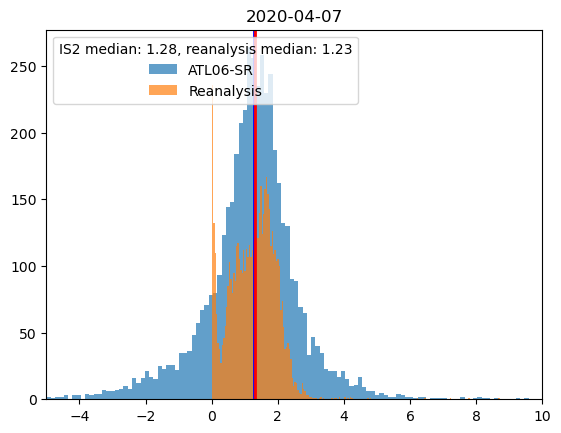

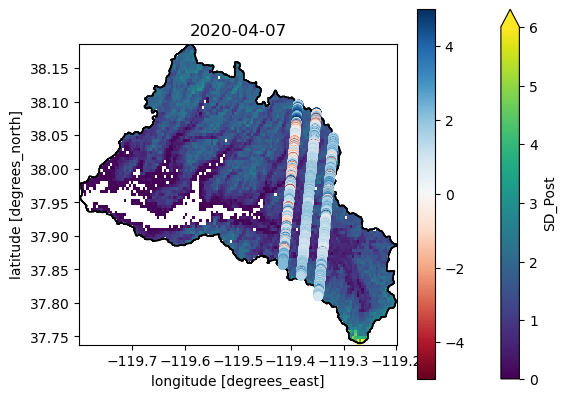

In [396]:
date_index = 13

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-04-07')

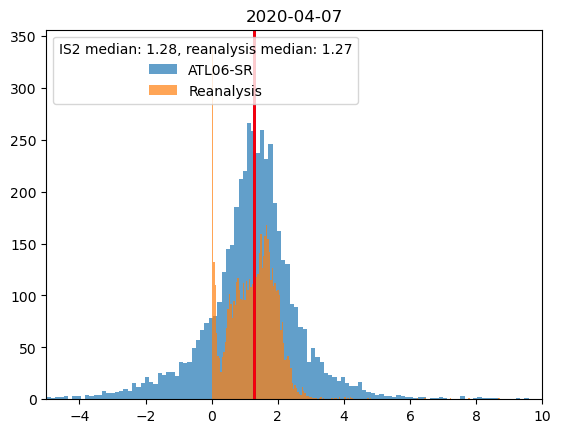

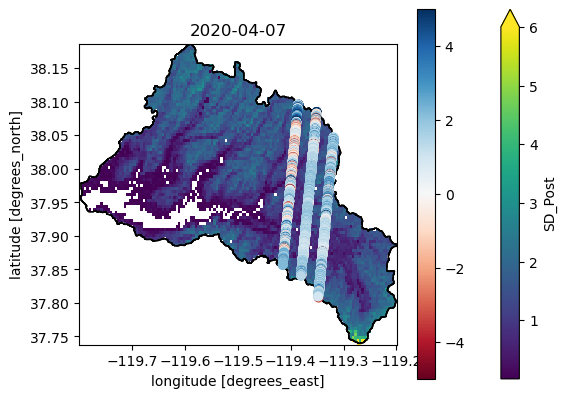

In [234]:
date_index = 13

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-04-12')

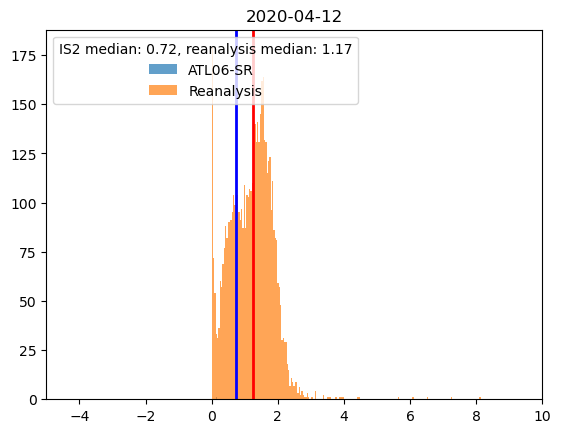

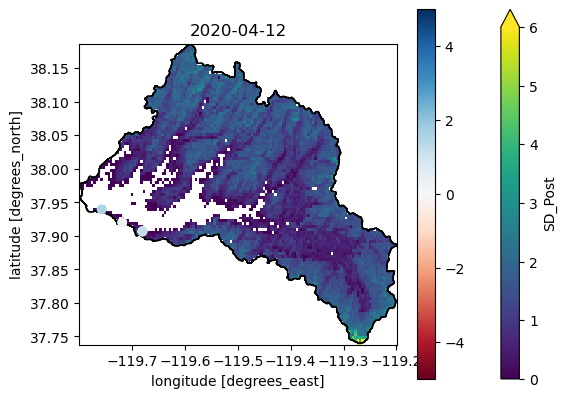

In [397]:
date_index = 14

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-04-12')

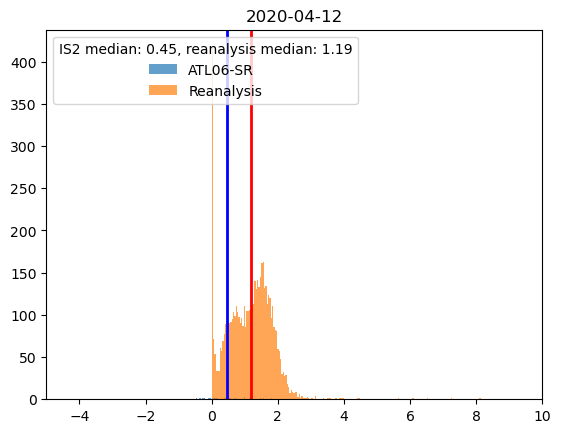

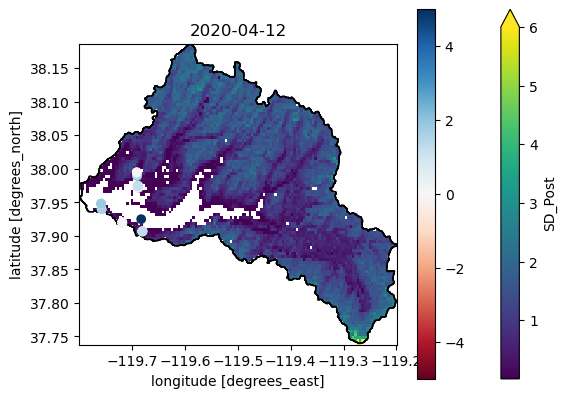

In [235]:
date_index = 14

reanalysis_test = reanalysis_clipped_2020[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

### Water Year 2021:

Text(0.5, 1.0, '2020-12-06')

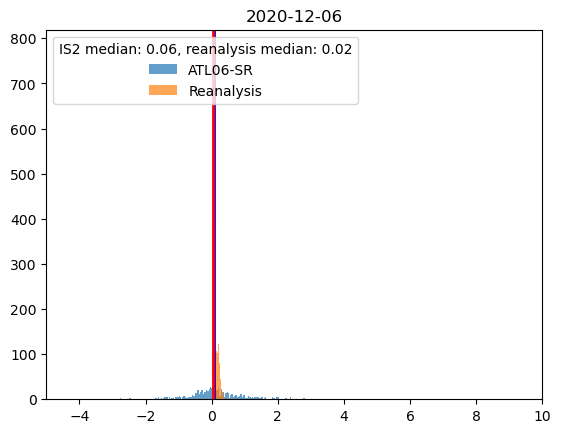

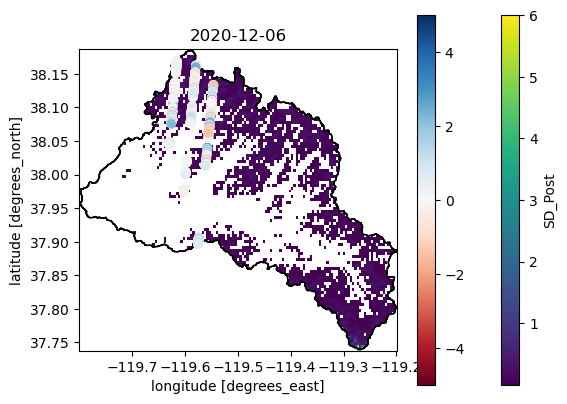

In [398]:
date_index = 15

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-12-06')

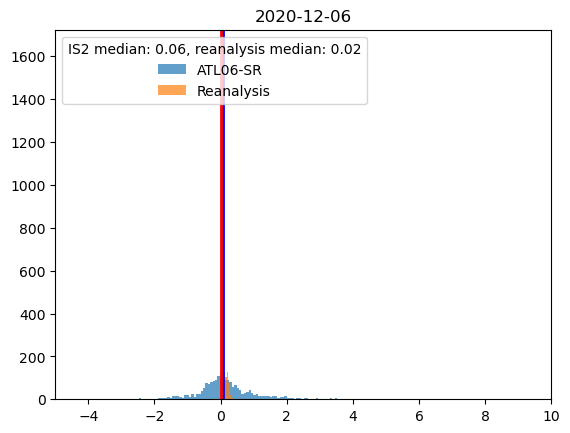

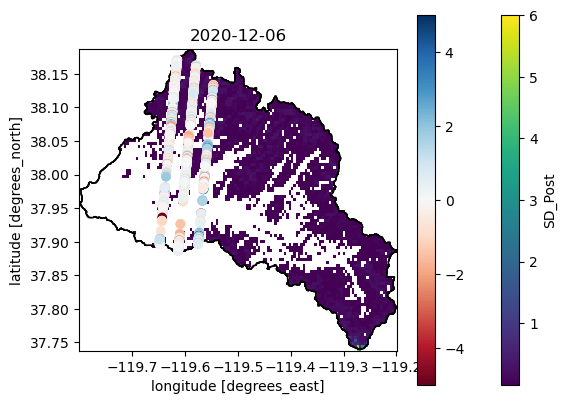

In [236]:
date_index = 15

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2020-12-08')

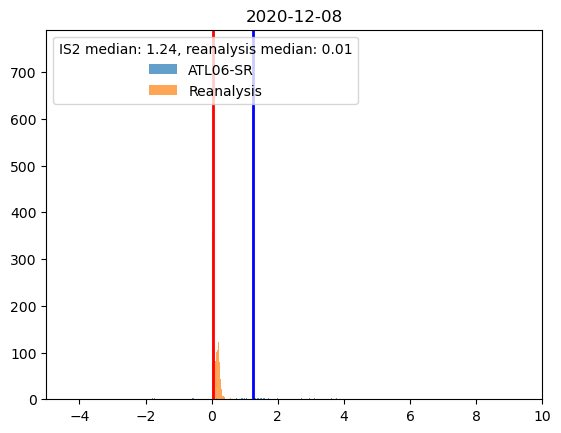

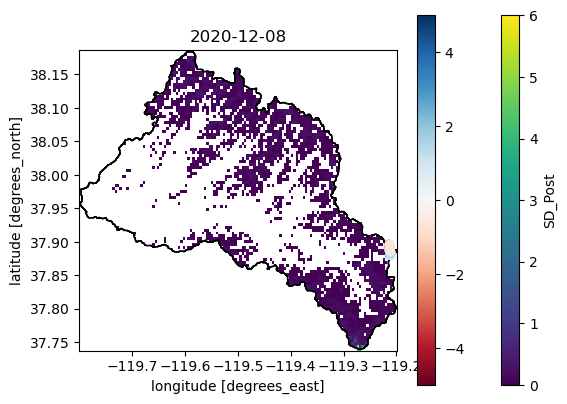

In [399]:
date_index = 16

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2020-12-08')

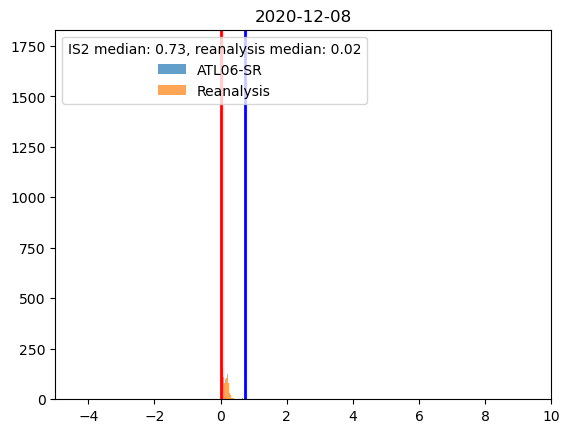

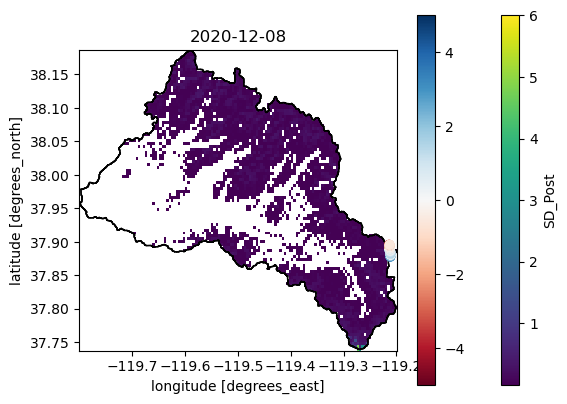

In [237]:
date_index = 16

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-01-10')

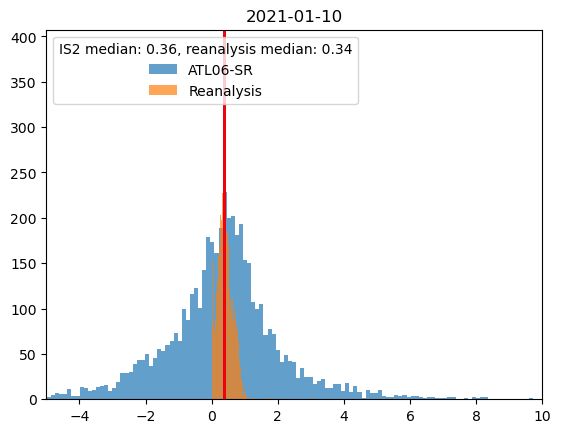

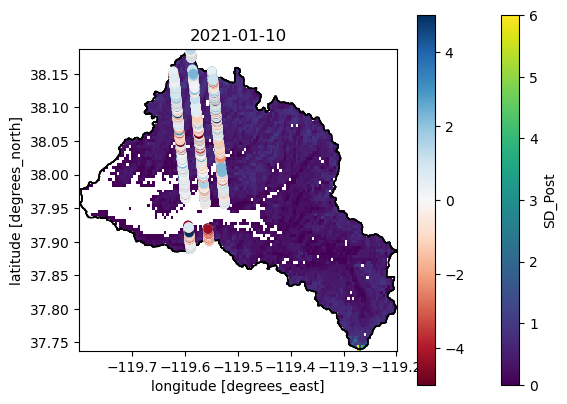

In [400]:
date_index = 17

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-01-10')

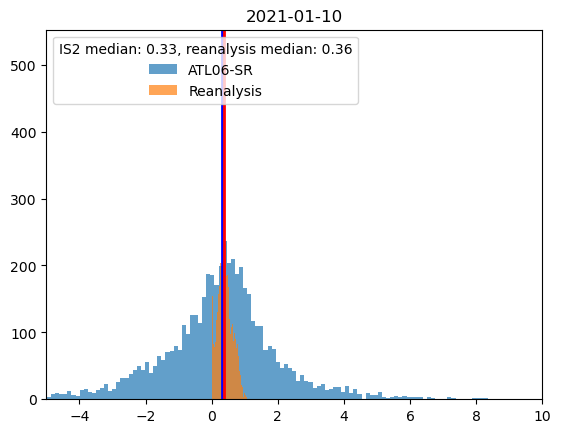

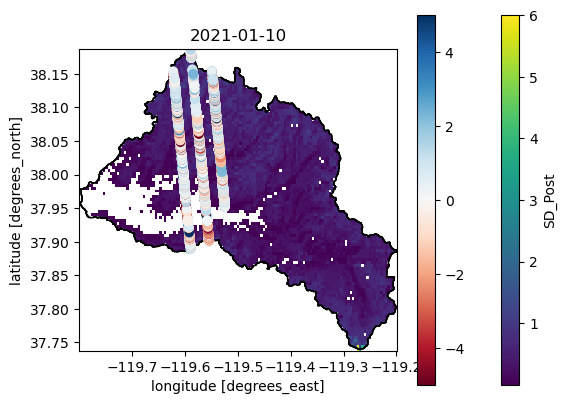

In [238]:
date_index = 17

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-02-02')

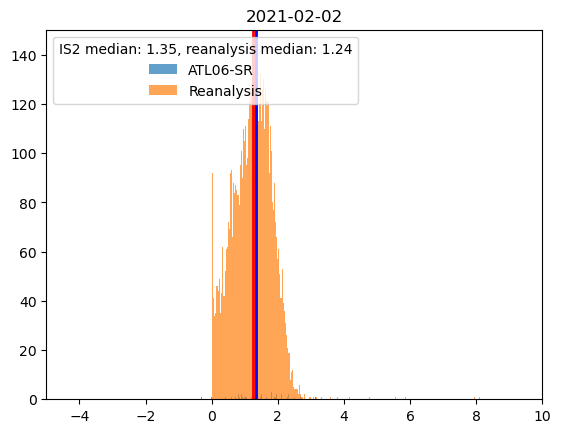

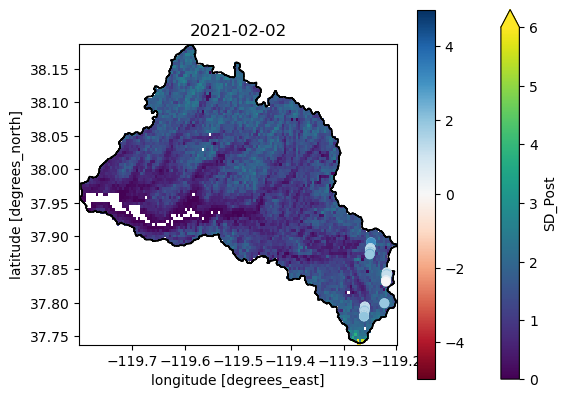

In [401]:
date_index = 18

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-02-02')

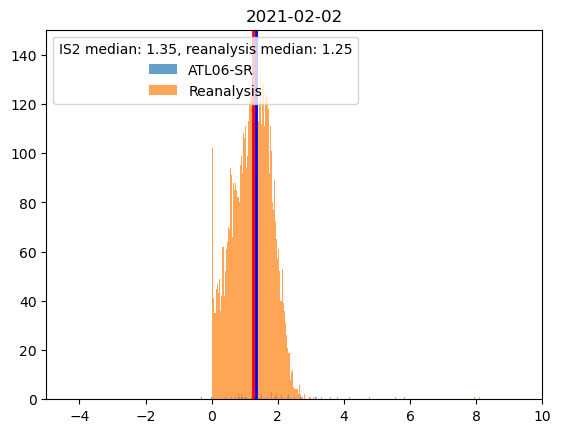

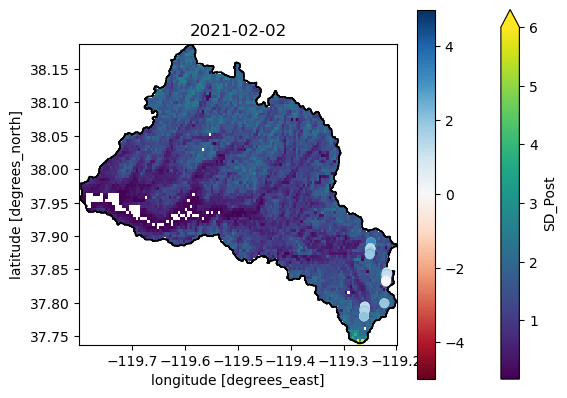

In [239]:
date_index = 18

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-02-08')

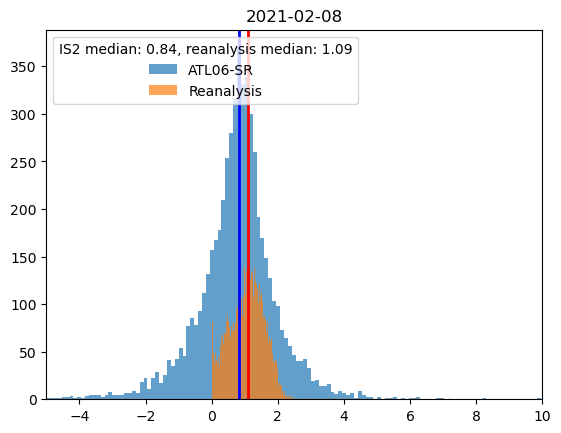

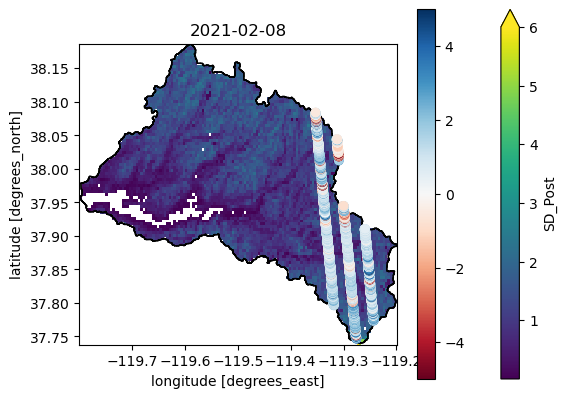

In [402]:
date_index = 19

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-02-08')

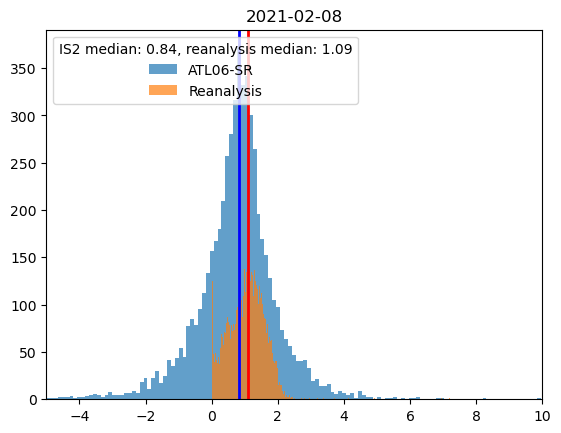

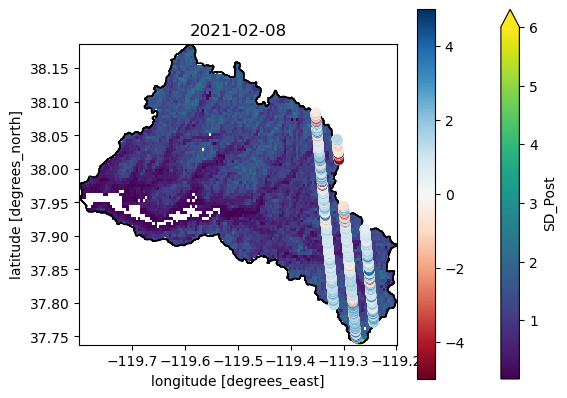

In [240]:
date_index = 19

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-03-07')

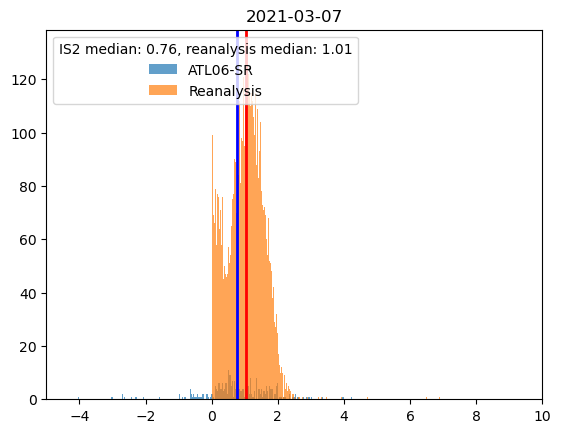

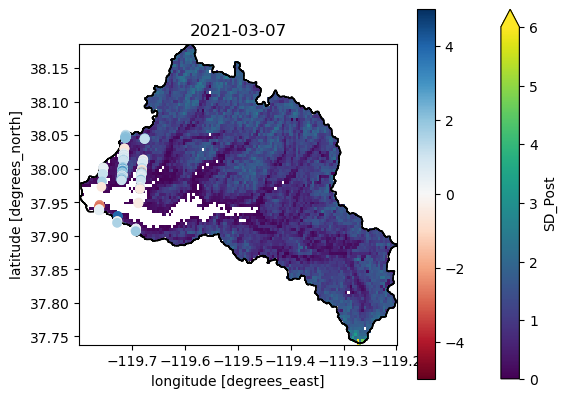

In [403]:
date_index = 20

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-03-07')

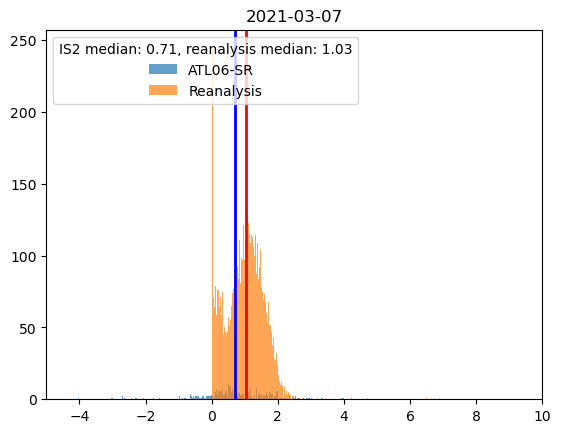

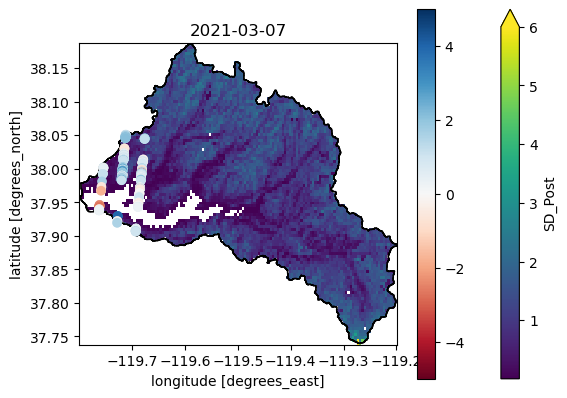

In [241]:
date_index = 20

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-03-13')

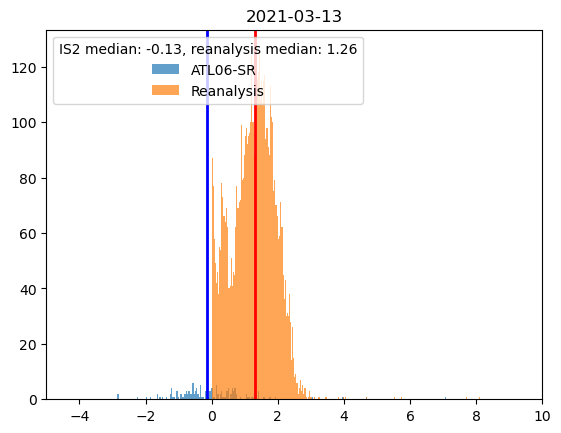

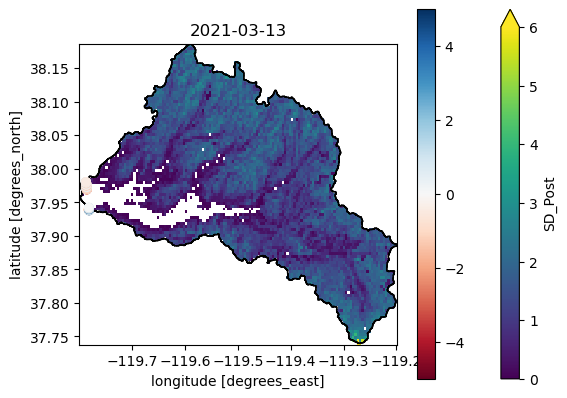

In [404]:
date_index = 21

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-03-13')

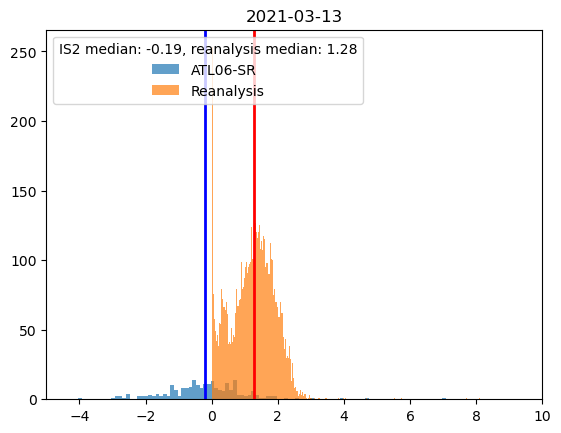

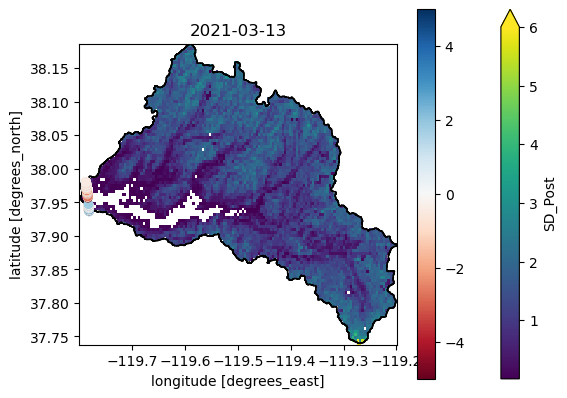

In [242]:
date_index = 21

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-04-05')

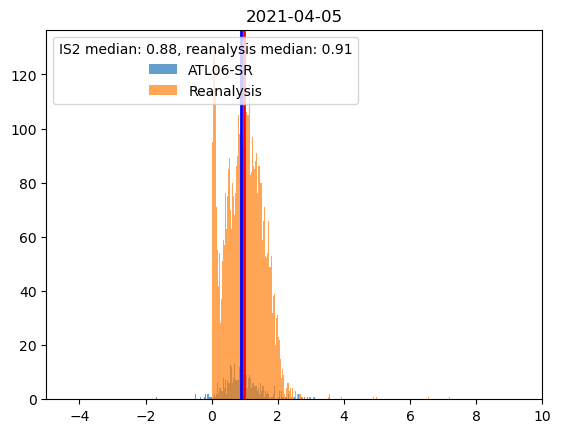

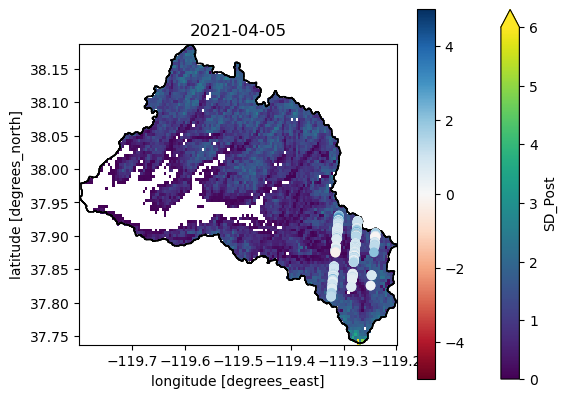

In [405]:
date_index = 22

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-04-05')

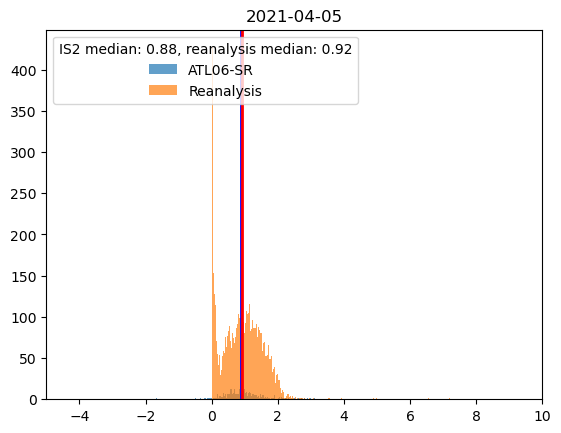

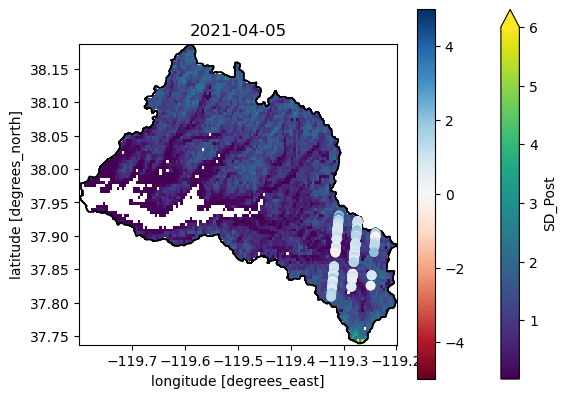

In [243]:
date_index = 22

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-04-11')

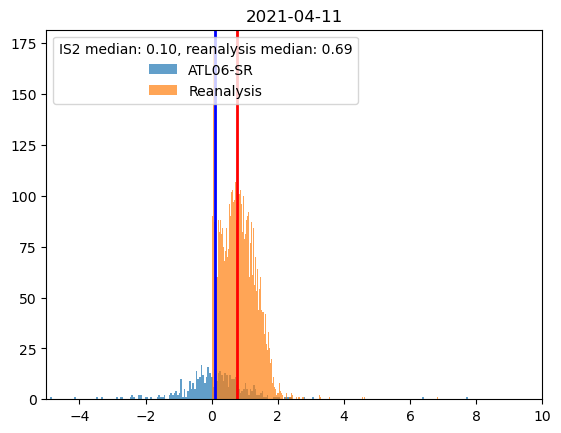

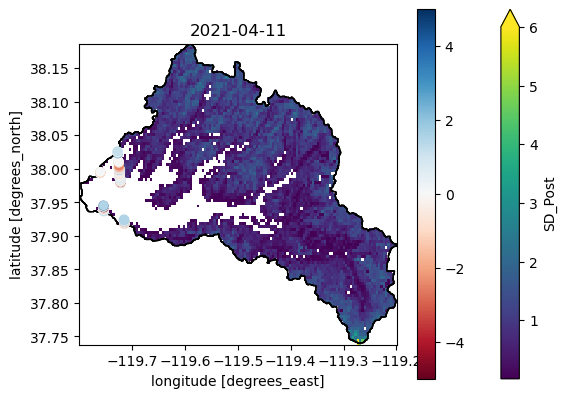

In [406]:
date_index = 23

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

IS2 median:  -0.05036776041424673
Reanalysis median:  0.8384


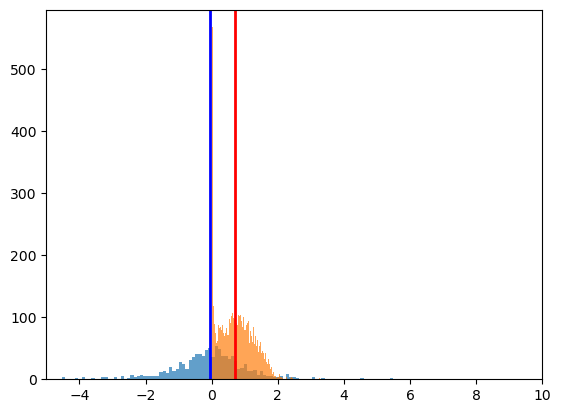

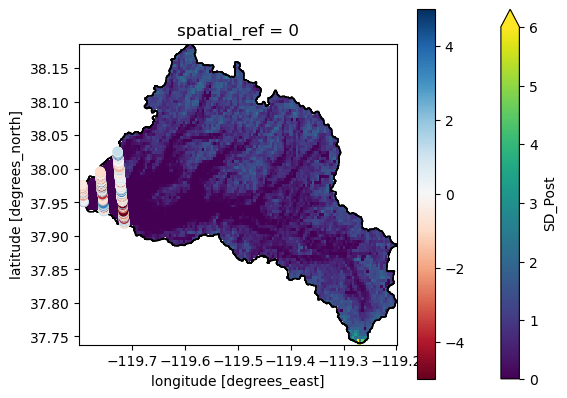

In [211]:
date_index = 23

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7)
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7)
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10);

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test.mean()>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)

print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

Text(0.5, 1.0, '2021-05-10')

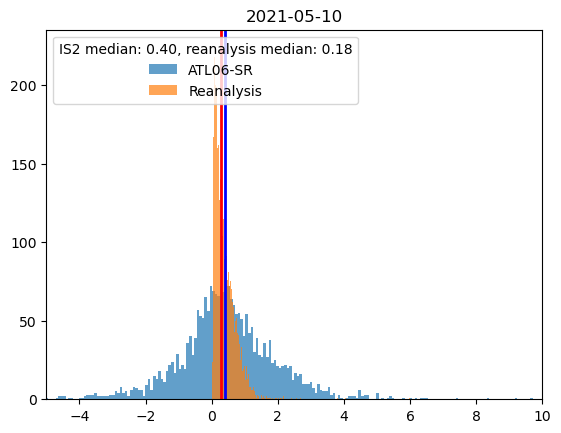

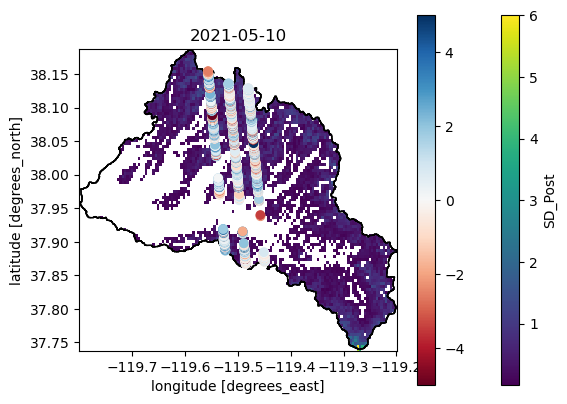

In [407]:
date_index = 24

# Subset the reanalysis snow depth and fsca data by the IS2 acquisition date:

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]
reanalysis_fsca = fsca_reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

# plot a histogram of the snow-on reanalysis and IS2 data, and display the median values for the basin in the legend title:

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_fsca>0.1).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_fsca>0).values.flatten()):.2f}')

# Plot the reanaysis snow depth where fsca > 0.1, and icesat2 data where fsca > 0.1:

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_fsca>0.1).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index]) & (atl06sr_gdf['reanalysis_fsca']> 0.1)].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

Text(0.5, 1.0, '2021-05-10')

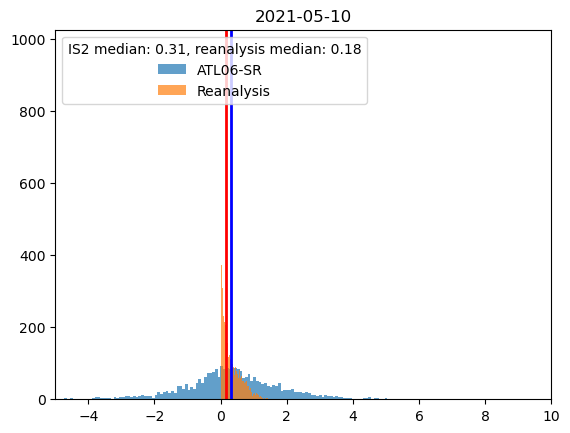

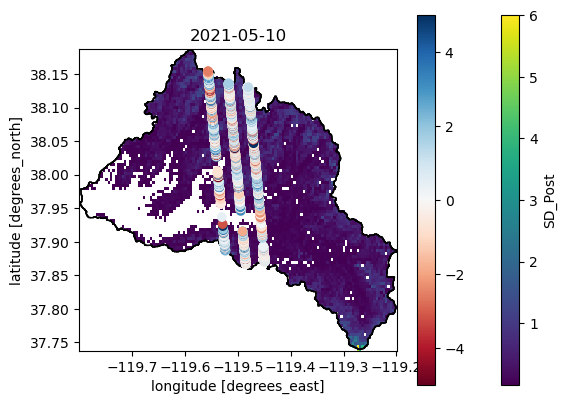

In [244]:
date_index = 24

reanalysis_test = reanalysis_clipped_2021[:,:,atl06sr_gdf[atl06sr_gdf['acqdate']==snowon_dates[date_index]]['dowy'].unique()]

fig, ax = plt.subplots()
ax.hist(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic'],\
            bins=250, alpha=0.7, label='ATL06-SR')
ax.hist(reanalysis_test.where(reanalysis_test>0).values.flatten(),\
            bins=250, alpha=0.7, label='Reanalysis')
ax.axvline(x = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']), linewidth=2, color='blue')
ax.axvline(x = np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()), linewidth=2, color='red')
plt.xlim(-5, 10)
plt.title(f'{snowon_dates[date_index]}')
plt.legend(loc='upper left',title=f'IS2 median: {np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']):.2f}, reanalysis median: {np.nanmedian(reanalysis_test.where(reanalysis_test>0).values.flatten()):.2f}')

fig, ax = plt.subplots()
reanalysis_test.where(reanalysis_test>0).plot(ax=ax, vmax=6)
tuol_outline.to_crs('epsg:4326').plot(ax=ax, edgecolor='k', facecolor='none')
atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])].to_crs('epsg:4326').plot(column='diff_plus_bicubic',ax=ax, cmap = 'RdBu', legend=True, vmin=-5, vmax=5)
plt.title(f'{snowon_dates[date_index]}')

# print('IS2 median: ', np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==snowon_dates[date_index])]['diff_plus_bicubic']))
# print('Reanalysis median: ',np.nanmedian(reanalysis_test.where(reanalysis_test>0.1).values.flatten()))

In [142]:
snowon_dates

[datetime.date(2018, 12, 11),
 datetime.date(2019, 1, 9),
 datetime.date(2019, 3, 12),
 datetime.date(2019, 4, 10),
 datetime.date(2019, 5, 14),
 datetime.date(2019, 12, 9),
 datetime.date(2019, 12, 11),
 datetime.date(2020, 1, 7),
 datetime.date(2020, 1, 13),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 3, 9),
 datetime.date(2020, 3, 10),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 12, 6),
 datetime.date(2020, 12, 8),
 datetime.date(2021, 1, 10),
 datetime.date(2021, 2, 2),
 datetime.date(2021, 2, 8),
 datetime.date(2021, 3, 7),
 datetime.date(2021, 3, 13),
 datetime.date(2021, 4, 5),
 datetime.date(2021, 4, 11),
 datetime.date(2021, 5, 10),
 datetime.date(2022, 1, 3),
 datetime.date(2022, 1, 8),
 datetime.date(2022, 2, 6),
 datetime.date(2022, 4, 3)]

In [205]:
snowon_dates[24]

datetime.date(2021, 5, 10)